# **NETFLIX RECOMENDATION**

# **1. INTRODUCCIÓ**

### **IMPORTS** 

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
import seaborn as sns
from wordcloud import WordCloud
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.feature_extraction import text


# **2. EDA**

### **2.1 LECTURA DEL DATASET** 

Primerament, descarreguem el Dataset i el visualitzem.

In [7]:
#file_path_test = 'C:\\Users\\USER\\Desktop\\3r\\1r semestre\\Aprenentatge Computacional\\Kaggle\\netflix_titles.csv'
file_path_test= 'C:\\Users\\Acer\\OneDrive\\Documentos\\Aprenentetge Computacional\\Cas Kaggle\\netflix_titles.csv\\netflix_titles.csv'
df_1 = pd.read_csv(file_path_test)

In [10]:
# Funció per expandir columnes
def expand_dataframe(df, columns_to_expand):
    """
    Expandeix les columnes especificades en un DataFrame, creant una fila per cada element a les llistes.
    :param df: DataFrame original.
    :param columns_to_expand: Columnes que contenen llistes separades per comes.
    :return: DataFrame expandit.
    """
    # Substituïm valors nuls amb cadenes buides per processar
    expanded_df = df.copy()
    for column in columns_to_expand:
        expanded_df[column] = expanded_df[column].fillna("").apply(lambda x: [item.strip() for item in x.split(",") if item.strip()])

    # Explosió de columnes
    for column in columns_to_expand:
        expanded_df = expanded_df.explode(column, ignore_index=True)

    # Tornem a posar valors nuls per coherència
    for column in columns_to_expand:
        expanded_df[column] = expanded_df[column].replace("", pd.NA)
    
    return expanded_df


# Columnes a expandir
columns_to_expand = ['cast', 'director', 'country', 'listed_in']

# Aplicar la funció per expandir
df = expand_dataframe(df_1, columns_to_expand)

# Guardar el resultat en un nou fitxer (opcional)
expanded_file_path = 'C:\\Users\\Acer\\OneDrive\\Documentos\\Aprenentetge Computacional\\Cas Kaggle\\netflix_titles.csv\\dataset_nou'

df.to_csv(expanded_file_path, index=False)

print(f"Dataset expandit i desat a: {expanded_file_path}")


Dataset expandit i desat a: C:\Users\Acer\OneDrive\Documentos\Aprenentetge Computacional\Cas Kaggle\netflix_titles.csv\dataset_nou


### **2.2 EXPLORACIÓ DE LES DADES**

In [11]:
print(f'El nostre dataset té {df.shape[0]} files i {df.shape[1]} columnes.\n')
print("Observem les 10 primeres files del dataset:")
df.head(10)
print(df.keys())
print(  )
print ('Tipus atributs:')
print (df.dtypes)

El nostre dataset té 201959 files i 12 columnes.

Observem les 10 primeres files del dataset:
Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')

Tipus atributs:
show_id         object
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object


Els atributs que tenim són:

* *show_id*: Identificador únic per a cada títol de Netflix.
* *type*: Tipus de contingut, especificant si és una "Movie" (pel·lícula) o un "TV Show" (programa de televisió).
* *title*: Títol de la pel·lícula o programa de televisió.
* *director*: Nom del director/directora de la producció. 
* *cast*: Llista dels actors principals que apareixen en el contingut.
* *country*: País o països on s'ha produït la pel·lícula o programa de televisió.
* *date_added*: Data en què el títol es va afegir a Netflix.
* *release_year*: Any en què es va estrenar el contingut.
* *rating*: Classificació de l'edat recomanada per al contingut.
* *duration*: Durada de la pel·lícula (en minuts) o nombre de temporades (seasons) per a programes de televisió.
* *listed_in*: Categories o gèneres en què el títol està classificat, com "Documentaries", "TV Dramas", etc.
* *description*: Breu descripció o sinopsi del contingut

In [12]:
print("Hi ha", len(df.type.value_counts()), "tipus de contingut.")
print("Hi ha", len(df.title.value_counts()), "diferents títols.") 

directors = df['director'].str.split(', ').explode().value_counts()
print("Hi ha", directors.count(), "diferents directors.")

artistes = df['cast'].str.split(', ').explode().value_counts()
print("Hi ha", artistes.count(), "diferents artistes.")

pais = df['country'].str.split(', ').explode().value_counts()
print("Hi ha", pais.count(), "paisos.")

print("Hi ha", len(df.date_added.value_counts()), "diferents dates en que es van afegir a netflix.")
print("Hi ha", len(df.release_year.value_counts()), "diferents anys en que es va estrenar el contingut.") 
print("Hi ha", len(df.rating.value_counts()), "classificacions per la recomenació d'edats pel contingut.")
print("Hi ha", len(df.duration.value_counts()), "diferentes duracions.") 

categories = df['listed_in'].str.split(', ').explode().value_counts()
print("Hi ha", categories.count(), "categories diferents.\n")

Hi ha 2 tipus de contingut.
Hi ha 8807 diferents títols.
Hi ha 4993 diferents directors.
Hi ha 36439 diferents artistes.
Hi ha 122 paisos.
Hi ha 1767 diferents dates en que es van afegir a netflix.
Hi ha 74 diferents anys en que es va estrenar el contingut.
Hi ha 14 classificacions per la recomenació d'edats pel contingut.
Hi ha 220 diferentes duracions.
Hi ha 42 categories diferents.



In [13]:
classificacio = df['rating'].unique()
print(classificacio)

['PG-13' 'TV-MA' 'PG' 'TV-14' 'TV-PG' 'TV-Y' 'TV-Y7' 'R' 'TV-G' 'G'
 'NC-17' nan 'NR' 'TV-Y7-FV' 'UR']


Els possibles significats de l'atribut *rating* són els següents:

1. **PG-13: Advertència per als pares (Parents Strongly Cautioned)**. Per a majors de 13 anys; pot tenir contingut inapropiat per a menors de 13. Inclou temes de violència o llenguatge moderat.

2. **TV-MA: Audiència madura (Mature Audience)**. Només per a adults, 17 anys o més. Inclou contingut explícit de violència, llenguatge fort o sexualitat.

3. **PG: Supervisió parental (Parental Guidance)**. Recomanat amb supervisió d’un adult. Pot no ser adequat per a nens petits, amb contingut de violència lleu o llenguatge moderat.

4. **TV-14: Advertència per als pares (Parents Strongly Cautioned)**. No recomanat per a menors de 14 anys sense supervisió d'un adult. Pot incloure violència o temes madurs.

5. **TV-PG: Supervisió parental suggerida (Parental Guidance Suggested)**. Pot no ser adequat per a nens petits; pot incloure llenguatge o temes lleus.

6. **TV-Y: Per a tots els nens (All Children)**. Adequat per a nens de totes les edats, sense violència ni llenguatge inapropiat.

7. **TV-Y7: Dirigit a nens més grans (Directed to Older Children)**. Adequat per a nens de 7 anys en endavant; podria incloure violència lleu de fantasia.

8. **R: Restringit (Restricted)**. Només per a majors de 17 o 18 anys, degut a violència intensa, contingut sexual o llenguatge explícit.

9. **TV-G: Audiència general (General Audience)**. Per a tot el públic, sense contingut objectable.

10. **G: Audiència general (General Audiences)**. Apte per a totes les edats, similar a TV-G.

11. **NC-17: Només per a adults (Adults Only)**. Contingut molt explícit, no apte per a menors de 17 anys, comú en cinema.

12. **NR: Sense classificar (Not Rated)**. No ha estat classificat oficialment, podria tenir qualsevol tipus de contingut.

13. **TV-Y7-FV: Dirigit a nens més grans amb violència de fantasia (Directed to Older Children - Fantasy Violence)**. Adequat per a majors de 7 anys, amb violència de fantasia que pot ser intensa per als més petits.

14. **UR: Sense classificació (Unrated)**. No té una classificació oficial; pot incloure qualsevol tipus de contingut.

Un cop observades les dades prenem les decisions següents:

*   *Show_id* - No ens interessa per predir el target i l'eliminem.
*   *Type* - Té 2 categories [Movie, TV Show], haurem de fer encoding.
*   *Title*- L'estudiarem, ja que pot proporcionar informació indirecta sobre la temàtica. 
*   *Director* - L'estudiem.
*   *Cast* - L'estudiem.
*   *Country* - L'estudiem.
*   *Date_added* - No és important per la classificació i per tant l'eliminem. 
*   *Release_year* - L'estudiem, ja que pot aportar informació perquè certs gèneres poden ser més comuns en dècades específiques. 
*   *Rating* - Hi ha 14 tipus diferents, per tant farem encoding i els separem en funció del type.
*   *Duration* - L'estudiem en funció del type, ja que ens interessa separar entre pel·lícules (en minuts) i sèries (en seasons). 
*   *Listed_in* - Hi ha 42 tipus diferents, per tant, farem agrupació. 
*   *Description* - L'estudiem.

### **2.4 DETECCIÓ D'OUTLIERS**

In [14]:
columnes= ['director', 'cast', 'country', 'release_year', 'duration', 'listed_in']

def analisi_outliers(df):
    cont = {}

    for columna in columnes:
        if pd.api.types.is_numeric_dtype(df[columna]):
            
            Q1 = df[columna].quantile(0.25)
            Q3 = df[columna].quantile(0.75)
            IQR = Q3 - Q1

            inferior = Q1 - 1.5 * IQR
            superior = Q3 + 1.5 * IQR

            outliers = df[(df[columna] < inferior) | (df[columna] > superior)]
            cont[columna] = len(outliers)

        elif pd.api.types.is_categorical_dtype(df[columna]) or pd.api.types.is_object_dtype(df[columna]):
            
            value_counts = df[columna].value_counts(normalize=True)
            rare_values = value_counts[value_counts < 0.01].index.tolist()

            cont[columna] = len(rare_values)

    ordenacio = {k: v for k, v in sorted(cont.items(), key=lambda item: item[1], reverse=True)}
    for columna, count in ordenacio.items():
        print(f"{columna:<20} {count}")

    return ordenacio

def modificacio_outliers(df, column, method):
    if pd.api.types.is_numeric_dtype(df[column]):
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        inferior = Q1 - 1.5 * IQR
        superior = Q3 + 1.5 * IQR

        # Substituir els outliers
        if method == 'median':
            median_value = df[column].median()
            df.loc[(df[column] < inferior) | (df[column] > superior), column] = median_value
        elif method == 'mean':
            mean_value = df[column].mean()
            df.loc[(df[column] < inferior) | (df[column] > superior), column] = mean_value
    

In [15]:
outliers = analisi_outliers(df)

cast                 36439
release_year         16472
director             4993
duration             186
country              102
listed_in            21


C:\Users\Acer\AppData\Local\Temp\ipykernel_21028\1833170283.py:19: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(df[columna]) or pd.api.types.is_object_dtype(df[columna]):
C:\Users\Acer\AppData\Local\Temp\ipykernel_21028\1833170283.py:19: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(df[columna]) or pd.api.types.is_object_dtype(df[columna]):
C:\Users\Acer\AppData\Local\Temp\ipykernel_21028\1833170283.py:19: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(df[columna]) or pd.api.types.is_object_dtype(df[columna]):
C:\Users\Acer\AppData\Local\Temp\ipykernel_21028\183317028

In [16]:
modificacio_outliers(df, 'release_year', 'mean')

C:\Users\Acer\AppData\Local\Temp\ipykernel_21028\1833170283.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2013.4525274932041' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[(df[column] < inferior) | (df[column] > superior), column] = mean_value


In [17]:
outliers_summary = analisi_outliers(df)

cast                 36439
release_year         8029
director             4993
duration             186
country              102
listed_in            21


C:\Users\Acer\AppData\Local\Temp\ipykernel_21028\1833170283.py:19: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(df[columna]) or pd.api.types.is_object_dtype(df[columna]):
C:\Users\Acer\AppData\Local\Temp\ipykernel_21028\1833170283.py:19: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(df[columna]) or pd.api.types.is_object_dtype(df[columna]):
C:\Users\Acer\AppData\Local\Temp\ipykernel_21028\1833170283.py:19: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(df[columna]) or pd.api.types.is_object_dtype(df[columna]):
C:\Users\Acer\AppData\Local\Temp\ipykernel_21028\183317028

# **3. PREPROCESSING**

### **3.1 ELIMINACIÓ D'ATRIBUTS**

Eliminem aquells atributs que considerem irrellevants per la classificació. 

In [18]:
df = df.drop(columns=['show_id', 'date_added'])
print(df.keys())

Index(['type', 'title', 'director', 'cast', 'country', 'release_year',
       'rating', 'duration', 'listed_in', 'description'],
      dtype='object')


### **3.1 TRACTAMENT DE NANS**

Primerament mirem si hi ha nans a les dades. 

In [19]:
def has_nans(df):
  return df.isna().sum().sum()>0

print (has_nans(df))

True


Hem vist que sí que hi ha, per tant, mirem la proporció que hi ha a cada atribut. 

In [20]:
print('Tenim nans en els atributs:')
nan_columns = df.columns[df.isna().sum()>0].tolist()
print (nan_columns)

not_nan_columns = df.columns[~(df.isna().sum()>0)].tolist()
print("  ")
print("Columnes amb nans i els seus percentatges:\n")
nan_columns = df.columns[df.isna().sum()>0].tolist()
print (df.loc[:,nan_columns].isna().sum()/len(df)*100)
not_nan_columns = df.columns[~(df.isna().sum()>0)].tolist()

Tenim nans en els atributs:
['director', 'cast', 'country', 'rating']
  
Columnes amb nans i els seus percentatges:

director    25.071921
cast         1.062592
country      5.890800
rating       0.034661
dtype: float64


Els atributs que contenen nans els podem dividir en tres subgrups:

1. **Atributs amb molts nans (>10%):** 
L'atribut *director (29.91%)* té una proporció elevada de valors nuls.
Al tenir un gran nombre de nans una bona opció seria eliminar l'atribut, ja que així evitem soroll. No obstant, considerem que l'atribut director és important i per tant, seria més útil aplicar knn-imputation per tal de predir els valors nuls en base a instàncies similars.

2. **Atributs amb menys d’un 10% de nans**
Els atributs *country (9.44%)* i *cast (9.37%)* també són importants i per tant, en comptes d'eliminar-los aplicariem Random Forest Classifier. 

3. **Atributs amb una proporció molt baixa de nans (<1%)**
L'atribut *rating (0.08%)* té molt pocs valors nuls.
En aquests casos, és preferible substituir els valors nuls amb la mitjana o un valor comú del conjunt de dades. Però fer-ho més precís hem decidit que la millor opció seria buscar la informació real d'aquests valors al Netflix. 

Primer tractem els nans de l'atribut **Rating**. Com que tenim una proporció molt petita, busquem els valors reals d'aquests valors a Netflix i els substituim.  

In [21]:
df.loc[df['title'] == 'Louis C.K. 2017', 'rating'] = 'R'
df.loc[df['title'] == 'Louis C.K.: Hilarious', 'rating'] = 'R'
df.loc[df['title'] == 'Louis C.K.: Live at the Comedy Store', 'rating'] = 'R'
df.loc[df['title'] == '13TH: A Conversation with Oprah Winfrey & Ava DuVernay', 'rating'] = 'PG-13'
df.loc[df['title'] == 'Gargantia on the Verdurous Planet', 'rating'] = 'TV-PG'
df.loc[df['title'] == 'Little Lunch', 'rating'] = 'TV-Y7'
df.loc[df['title'] == 'My Honor Was Loyalty', 'rating'] = 'PG-13'

In [22]:
print('Tenim nans en els atributs:')
nan_columns = df.columns[df.isna().sum()>0].tolist()
print (nan_columns)

not_nan_columns = df.columns[~(df.isna().sum()>0)].tolist()
print("  ")
print("Columnes amb nans i els seus percentatges:\n")
nan_columns = df.columns[df.isna().sum()>0].tolist()
print (df.loc[:,nan_columns].isna().sum()/len(df)*100)
not_nan_columns = df.columns[~(df.isna().sum()>0)].tolist()

Tenim nans en els atributs:
['director', 'cast', 'country']
  
Columnes amb nans i els seus percentatges:

director    25.071921
cast         1.062592
country      5.890800
dtype: float64


Per eliminar els nans de l'atribut **Country** per aconseguir una millor predicció utlitzem **Random Forest Classifier**. 

C:\Users\Acer\AppData\Local\Temp\ipykernel_21028\2632697236.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  known_country['country'] = le_country.fit_transform(known_country['country'])


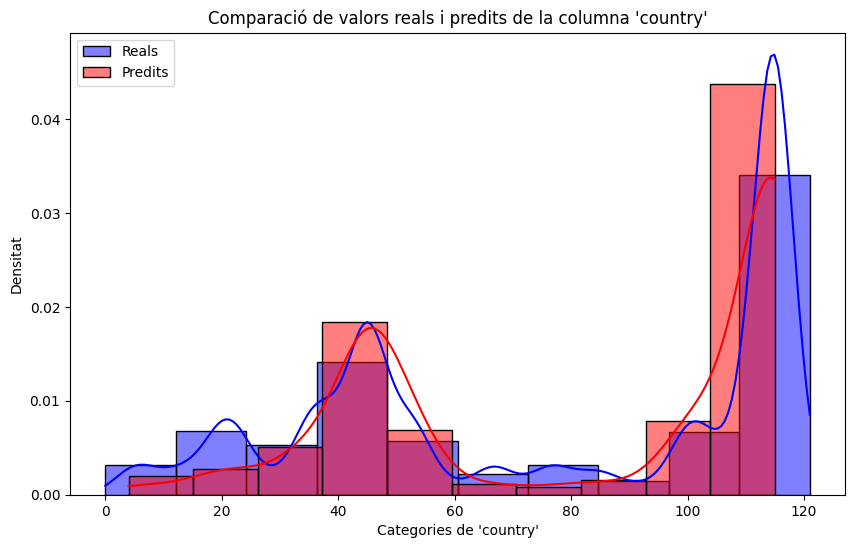

In [23]:
atributs = ['type', 'title', 'director', 'cast', 'release_year', 'rating', 'duration', 'listed_in', 'description']

label_encoders = {}
for column in atributs:  
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])  
    label_encoders[column] = le

known_country = df[df['country'].notnull()]
unknown_country = df[df['country'].isnull()]

le_country = LabelEncoder()
known_country['country'] = le_country.fit_transform(known_country['country'])

X_train = known_country.drop('country', axis=1)
y_train = known_country['country']
X_unknown = unknown_country.drop('country', axis=1)

rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

predicted_countries = rfc.predict(X_unknown)
predicted_countries = le_country.inverse_transform(predicted_countries)

df.loc[df['country'].isnull(), 'country'] = predicted_countries

plt.figure(figsize=(10, 6))
sns.histplot(known_country['country'], color='blue', label='Reals', kde=True, stat='density', bins=10)
sns.histplot(le_country.transform(predicted_countries), color='red', label='Predits', kde=True, stat='density', bins=10)

plt.legend()
plt.title("Comparació de valors reals i predits de la columna 'country'")
plt.xlabel("Categories de 'country'")
plt.ylabel("Densitat")
plt.show()

for column, le in label_encoders.items():
    df[column] = le.inverse_transform(df[column])


In [24]:
print('Tenim nans en els atributs:')
nan_columns = df.columns[df.isna().sum()>0].tolist()
print (nan_columns)

not_nan_columns = df.columns[~(df.isna().sum()>0)].tolist()
print("  ")
print("Columnes amb nans i els seus percentatges:\n")
nan_columns = df.columns[df.isna().sum()>0].tolist()
print (df.loc[:,nan_columns].isna().sum()/len(df)*100)
not_nan_columns = df.columns[~(df.isna().sum()>0)].tolist()

Tenim nans en els atributs:
['director', 'cast']
  
Columnes amb nans i els seus percentatges:

director    25.071921
cast         1.062592
dtype: float64


Per eliminar els valors nuls dels atributs **Cast i Director** en comptes d'utilitzar Random Forest Classifier, utilitzem **KNN Imputer**, ja que hi ha un nombre molt gran d'actors i directors. 

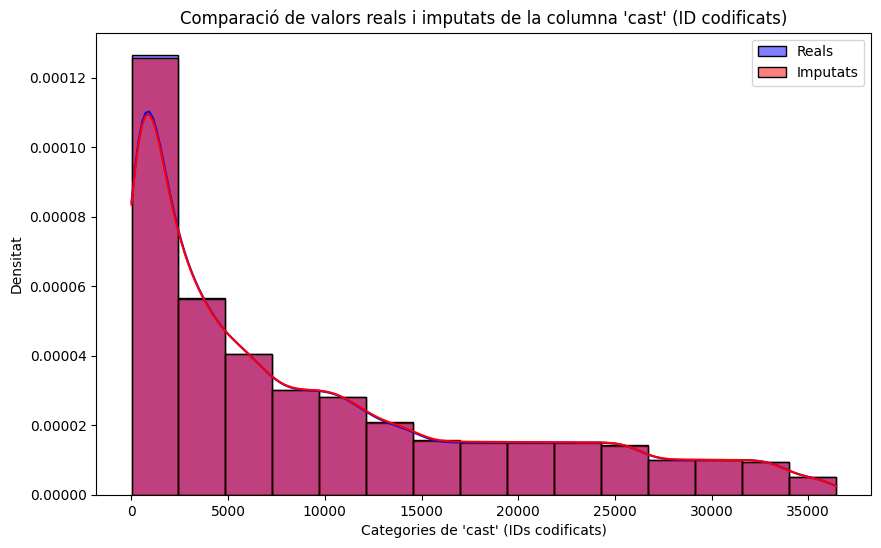

In [25]:
atribtus = ['type', 'country', 'release_year', 'rating', 'duration', 'listed_in']

# Pas 1: Codificació de les columnes categòriques
label_encoders = {}

for col in atribtus:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Pas 2: Codificació individual per a la columna 'cast'
cast_mapping = {name: idx for idx, name in enumerate(df['cast'].value_counts().index, 1)}
df['cast'] = df['cast'].map(cast_mapping)

# Pas 3: Imputació KNN
knn_imputer = KNNImputer(n_neighbors=5)
df_imputed = knn_imputer.fit_transform(df[atribtus + ['cast']])

# Convertir el resultat a DataFrame
df_imputed = pd.DataFrame(df_imputed, columns=atribtus + ['cast'])

# Pas 4: Generació del gràfic (ABANS de decodificar les dades)
# Dividim els valors reals i imputats
real_cast = df[df['cast'].notnull()]['cast']
imputed_cast = df_imputed['cast']

# Gràfic
plt.figure(figsize=(10, 6))
sns.histplot(real_cast, color='blue', label='Reals', kde=True, stat='density', bins=15)
sns.histplot(imputed_cast, color='red', label='Imputats', kde=True, stat='density', bins=15)

# Etiquetes i títols
plt.legend()
plt.title("Comparació de valors reals i imputats de la columna 'cast' (ID codificats)")
plt.xlabel("Categories de 'cast' (IDs codificats)")
plt.ylabel("Densitat")
plt.show()

# Pas 5: Reconstrucció de les dades (DESPRÉS del gràfic)
for col in atribtus + ['cast']:
    df[col] = df_imputed[col]

reverse_cast_mapping = {v: k for k, v in cast_mapping.items()}
df['cast'] = df['cast'].apply(lambda x: np.nan if np.isnan(x) else reverse_cast_mapping.get(int(x), np.nan))

for column, le in label_encoders.items():
    if column in df.columns:
        df[column] = le.inverse_transform(df[column].astype(int))

In [26]:
print('Tenim nans en els atributs:')
nan_columns = df.columns[df.isna().sum()>0].tolist()
print (nan_columns)

not_nan_columns = df.columns[~(df.isna().sum()>0)].tolist()
print("  ")
print("Columnes amb nans i els seus percentatges:\n")
nan_columns = df.columns[df.isna().sum()>0].tolist()
print (df.loc[:,nan_columns].isna().sum()/len(df)*100)
not_nan_columns = df.columns[~(df.isna().sum()>0)].tolist()

Tenim nans en els atributs:
['director']
  
Columnes amb nans i els seus percentatges:

director    25.071921
dtype: float64


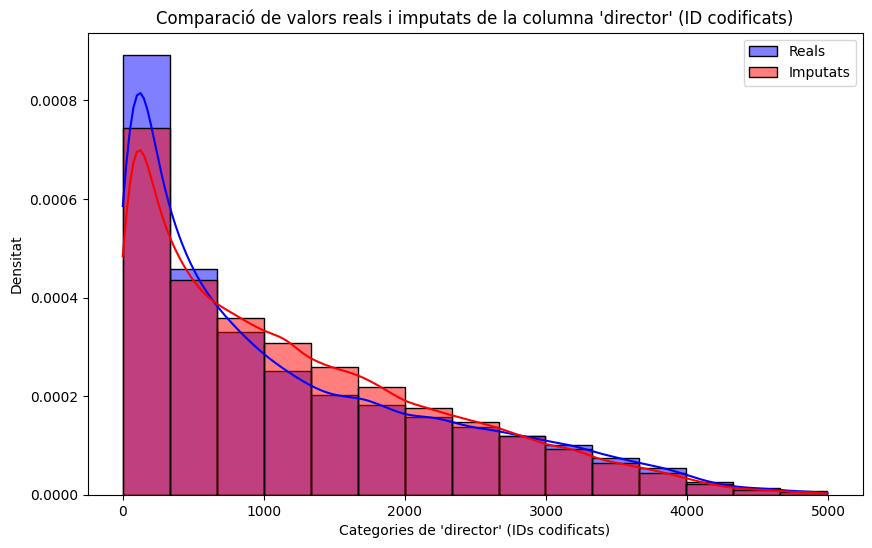

In [27]:
atribtus = ['type', 'country', 'cast', 'release_year', 'rating', 'duration', 'listed_in']

# Pas 1: Codificació de les columnes categòriques
label_encoders = {}

for col in atribtus:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Pas 2: Codificació individual per a la columna 'cast'
director_mapping = {name: idx for idx, name in enumerate(df['director'].value_counts().index, 1)}
df['director'] = df['director'].map(director_mapping)

# Pas 3: Imputació KNN
knn_imputer = KNNImputer(n_neighbors=5)
df_imputed = knn_imputer.fit_transform(df[atribtus + ['director']])

# Convertir el resultat a DataFrame
df_imputed = pd.DataFrame(df_imputed, columns=atribtus + ['director'])

# Pas 4: Generació del gràfic (ABANS de decodificar les dades)
# Dividim els valors reals i imputats
real_director = df[df['director'].notnull()]['director']
imputed_director = df_imputed['director']

# Gràfic
plt.figure(figsize=(10, 6))
sns.histplot(real_director, color='blue', label='Reals', kde=True, stat='density', bins=15)
sns.histplot(imputed_director, color='red', label='Imputats', kde=True, stat='density', bins=15)

# Etiquetes i títols
plt.legend()
plt.title("Comparació de valors reals i imputats de la columna 'director' (ID codificats)")
plt.xlabel("Categories de 'director' (IDs codificats)")
plt.ylabel("Densitat")
plt.show()

# Pas 5: Reconstrucció de les dades (DESPRÉS del gràfic)
for col in atribtus + ['director']:
    df[col] = df_imputed[col]

reverse_director_mapping = {v: k for k, v in director_mapping.items()}
df['director'] = df['director'].apply(lambda x: np.nan if np.isnan(x) else reverse_director_mapping.get(int(x), np.nan))

for column, le in label_encoders.items():
    if column in df.columns:
        df[column] = le.inverse_transform(df[column].astype(int))

In [1]:
#print(cast_mapping)
#print(director_mapping)

In [30]:
print('Tenim nans en els atributs:')
nan_columns = df.columns[df.isna().sum()>0].tolist()
print (nan_columns)

not_nan_columns = df.columns[~(df.isna().sum()>0)].tolist()
print("  ")
print("Columnes amb nans i els seus percentatges:\n")
nan_columns = df.columns[df.isna().sum()>0].tolist()
print (df.loc[:,nan_columns].isna().sum()/len(df)*100)
not_nan_columns = df.columns[~(df.isna().sum()>0)].tolist() 

Tenim nans en els atributs:
[]
  
Columnes amb nans i els seus percentatges:

Series([], dtype: float64)


### **3.3 AGRUPACIÓ**

In [31]:
unique_genres = set(genre.strip() for genres in df['listed_in'] for genre in genres.split(','))
print(len(unique_genres))
print(unique_genres)


42
{'TV Thrillers', 'Music & Musicals', 'Thrillers', 'Horror Movies', 'Crime TV Shows', 'Sci-Fi & Fantasy', 'Teen TV Shows', 'TV Comedies', 'Science & Nature TV', 'TV Dramas', 'TV Mysteries', 'Classic Movies', 'Spanish-Language TV Shows', 'Romantic Movies', 'Anime Series', 'Cult Movies', 'TV Sci-Fi & Fantasy', 'Dramas', 'TV Horror', 'Reality TV', 'Children & Family Movies', 'TV Shows', "Kids' TV", 'Comedies', 'British TV Shows', 'Independent Movies', 'Anime Features', 'Docuseries', 'International Movies', 'Romantic TV Shows', 'LGBTQ Movies', 'Faith & Spirituality', 'International TV Shows', 'Movies', 'Stand-Up Comedy', 'Action & Adventure', 'Documentaries', 'Korean TV Shows', 'Classic & Cult TV', 'Stand-Up Comedy & Talk Shows', 'Sports Movies', 'TV Action & Adventure'}


In [32]:
group_mapping = {
    'Horror': ['Thrillers', 'Horror Movies'],
    'TV Horror': ['TV Horror', 'Crime TV Shows', 'TV Mysteries', 'TV Thrillers'],
    'Drama and romance': ['Dramas', 'Romantic Movies', 'Independent Movies', 'Movies'],
    'TV Drama and romance': ['TV Dramas', 'Romantic TV Shows', 'Teen TV Shows'],
    'Comedy': ['Comedies', 'Stand-Up Comedy'],
    'TV Comedy': ['TV Comedies', 'Stand-Up Comedy & Talk Shows'],
    'International': ['International Movies'],
    'TV International': ['International TV Shows', 'British TV Shows', 'Spanish-Language TV Shows', 'Korean TV Shows'],
    'Family': ['Children & Family Movies'],
    'TV Family': ["Kids' TV"],
    'Fantasy': ['Sci-Fi & Fantasy'],
    'TV Fantasy': ['TV Sci-Fi & Fantasy'],
    'Action & Adventure': ['Action & Adventure'],
    'TV Action & Adventure': ['TV Action & Adventure'],
    'Documentaries & education': ['Documentaries', 'Faith & Spirituality'],
    'TV Documentaries & education': ['Docuseries', 'Science & Nature TV'],
    'Anime': ['Anime Features'],
    'TV Anime': ['Anime Series'],
    'Music': ['Music & Musicals'],
    'Sports': ['Sports Movies'],
    'Classic & cult': ['Classic Movies', 'Cult Movies', 'LGBTQ Movies'],
    'TV Classic & Cult': ['Classic & Cult TV'],
    'TV Reality': ['TV Shows', 'Reality TV']
}

def group_categories(row, group_mapping):
    categories = row.split(',') 
    new_categories = []
    
    for category in categories:
        category = category.strip()  
        matched = False
        for group, values in group_mapping.items():
            if category in values:  
                new_categories.append(group)  
                matched = True
                break  
        if not matched:
            new_categories.append(category)  
    
    return ','.join(new_categories)  

df['listed_in'] = df['listed_in'].apply(lambda x: group_categories(x, group_mapping))

### **3.3 NORMALITZACIÓ**

### **3.4 VISUALITZACIÓ DELS ATRIBUTS**

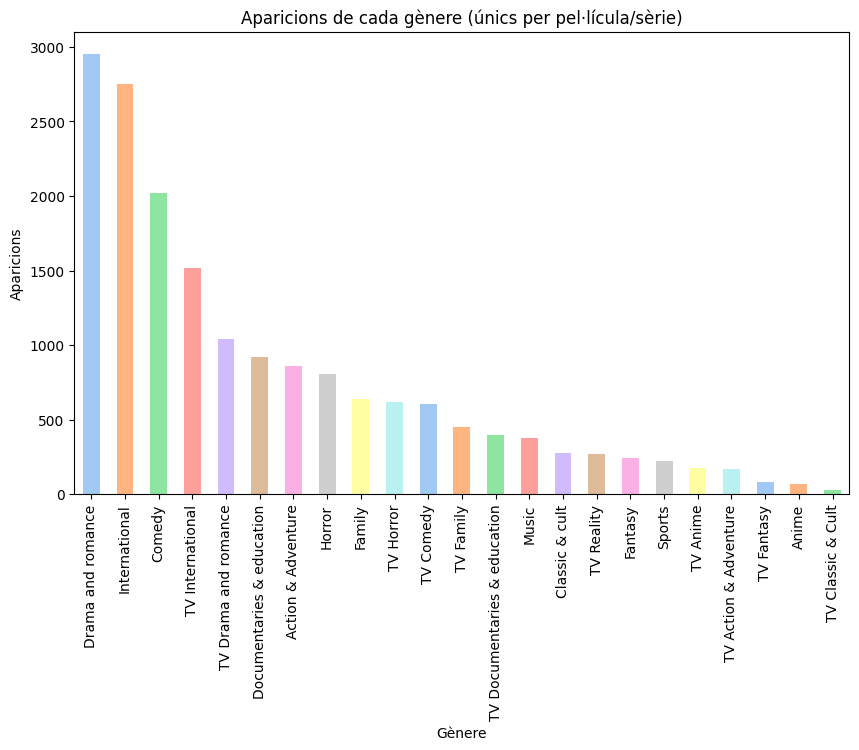

In [33]:
# Crear una llista per emmagatzemar valors únics per pel·lícula/sèrie
all_genres = []

# Per cada pel·lícula/sèrie, extreure els gèneres únics i comptar-los
for _, group in df.groupby('title'):  # Agrupem pel títol per assegurar-nos que tractem cada pel·lícula/sèrie per separat
    unique_genres = set(genre.strip() for genres in group['listed_in'] for genre in genres.split(','))
    all_genres.extend(unique_genres)  # Afegim els gèneres únics al conjunt global

# Comptar les aparicions de cada gènere
genre_counts = pd.Series(all_genres).value_counts()
colors = sns.color_palette("pastel", len(genre_counts))

# Generar el gràfic
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar', color=colors)
plt.title("Aparicions de cada gènere (únics per pel·lícula/sèrie)")
plt.xlabel("Gènere")
plt.ylabel("Aparicions")
plt.show()


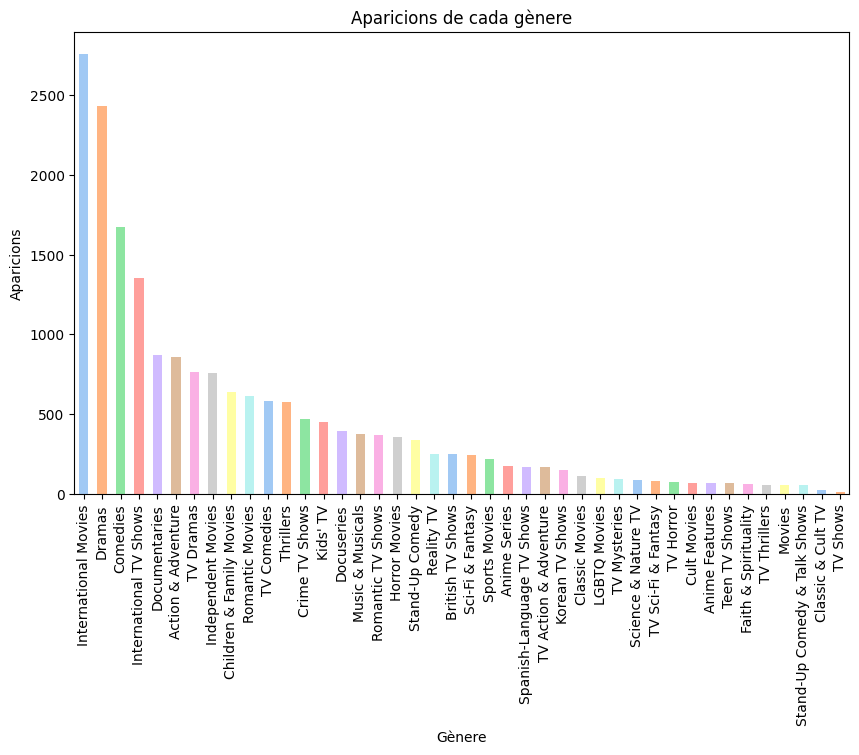

In [ ]:
"""
all_genres = [genre.strip() for genres in df['listed_in'] for genre in genres.split(',')]

genre_counts = pd.Series(all_genres).value_counts()
colors = sns.color_palette("pastel", len(genre_counts))

plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar', color=colors)
plt.title("Aparicions de cada gènere")
plt.xlabel("Gènere")
plt.ylabel("Aparicions")
plt.show()
"""


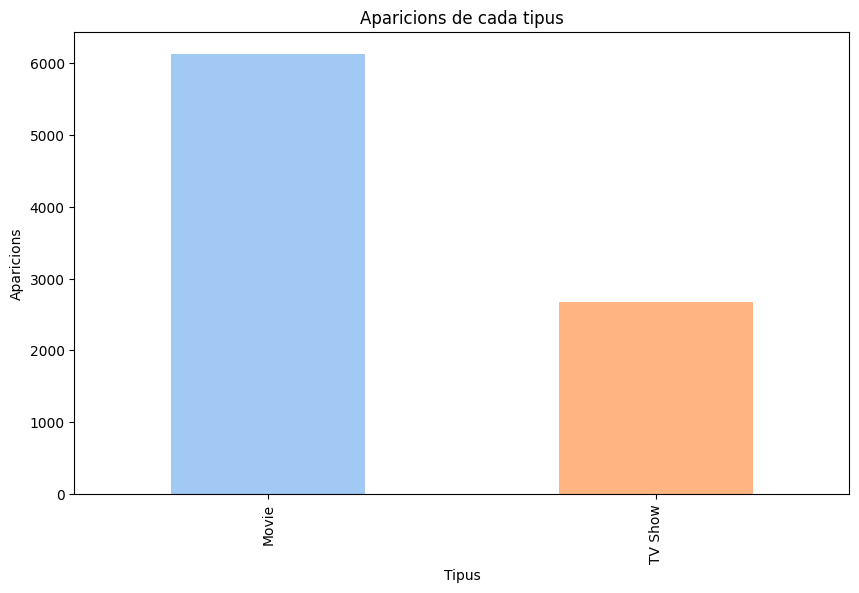

'\ntypes = [genre.strip() for genres in df[\'type\'] for genre in genres.split(\',\')]\ntype_counts = pd.Series(types).value_counts()\ncolors = sns.color_palette("pastel", len(type_counts))\n\nplt.figure(figsize=(10, 6))\ntype_counts.plot(kind=\'bar\', color=colors)\nplt.title("Aparicions de cada tipus")\nplt.xlabel("Tipus")\nplt.ylabel("Aparicions")\nplt.show()\n'

In [34]:
types = [type_.strip() for type_ in df.drop_duplicates(subset=['title', 'type'])['type']]
type_counts = pd.Series(types).value_counts()
colors = sns.color_palette("pastel", len(type_counts))

plt.figure(figsize=(10, 6))
type_counts.plot(kind='bar', color=colors)
plt.title("Aparicions de cada tipus")
plt.xlabel("Tipus")
plt.ylabel("Aparicions")
plt.show()

"""
types = [genre.strip() for genres in df['type'] for genre in genres.split(',')]
type_counts = pd.Series(types).value_counts()
colors = sns.color_palette("pastel", len(type_counts))

plt.figure(figsize=(10, 6))
type_counts.plot(kind='bar', color=colors)
plt.title("Aparicions de cada tipus")
plt.xlabel("Tipus")
plt.ylabel("Aparicions")
plt.show()
"""

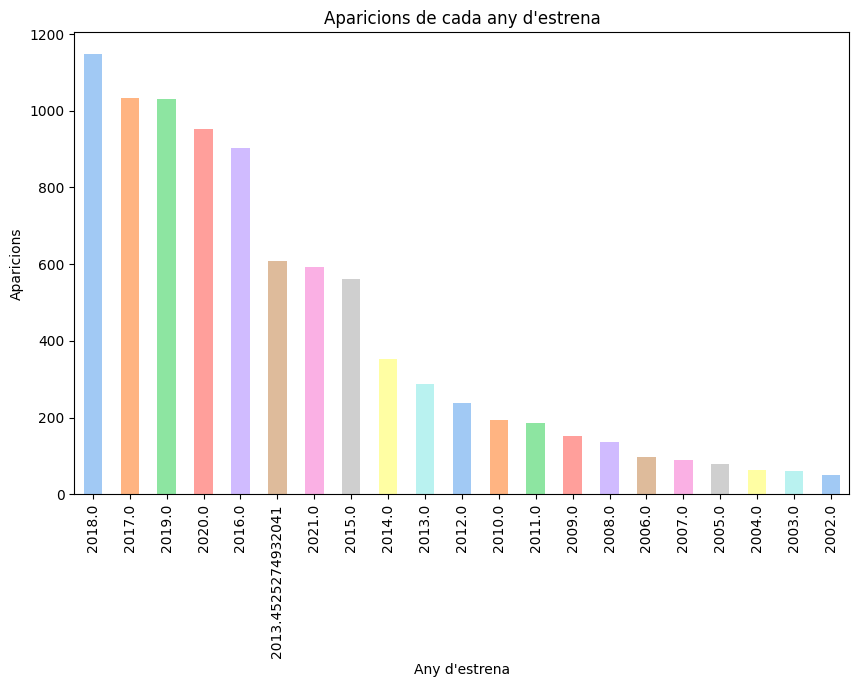

'\nrelease_years = [genre.strip() for genres in df[\'release_year\'] for genre in genres.split(\',\')]\ntype_counts = pd.Series(release_years).value_counts()\ncolors = sns.color_palette("pastel", len(type_counts))\n\nplt.figure(figsize=(10, 6))\ntype_counts.plot(kind=\'bar\', color=colors)\nplt.title("Aparicions de cada any d\'estrena")\nplt.xlabel("Tipus")\nplt.ylabel("Aparicions")\nplt.show()\n'

In [35]:
release_years = [year for year in df.drop_duplicates(subset=['title', 'release_year'])['release_year']]
year_counts = pd.Series(release_years).value_counts()
colors = sns.color_palette("pastel", len(year_counts))

plt.figure(figsize=(10, 6))
year_counts.plot(kind='bar', color=colors)
plt.title("Aparicions de cada any d'estrena")
plt.xlabel("Any d'estrena")
plt.ylabel("Aparicions")
plt.show()

"""
release_years = [genre.strip() for genres in df['release_year'] for genre in genres.split(',')]
type_counts = pd.Series(release_years).value_counts()
colors = sns.color_palette("pastel", len(type_counts))

plt.figure(figsize=(10, 6))
type_counts.plot(kind='bar', color=colors)
plt.title("Aparicions de cada any d'estrena")
plt.xlabel("Tipus")
plt.ylabel("Aparicions")
plt.show()
"""

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


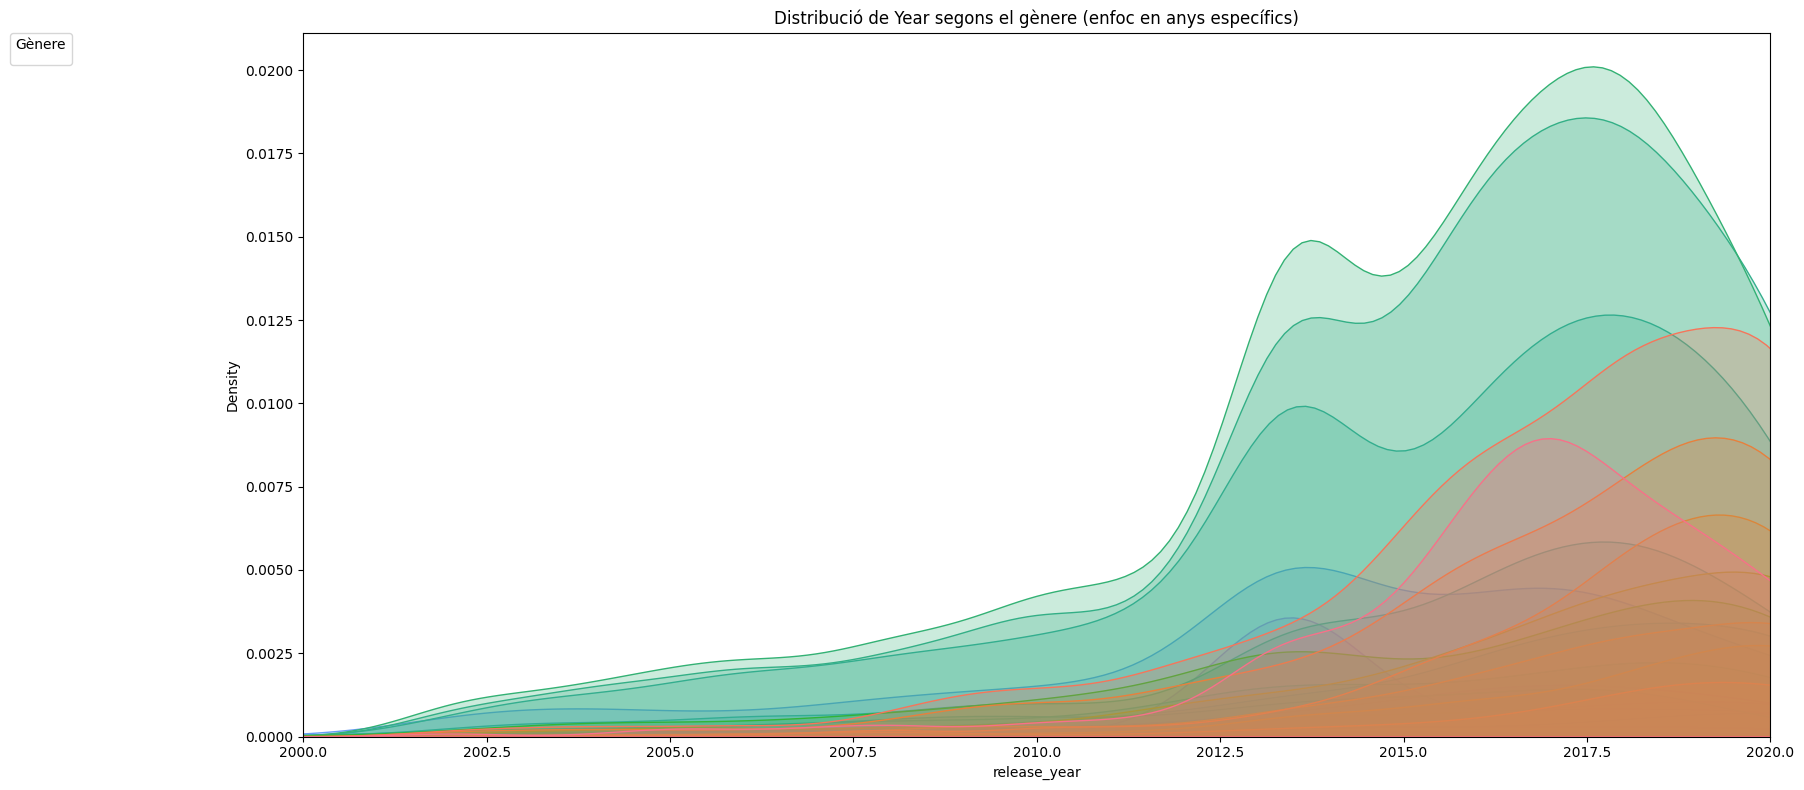

'\ndf[\'release_year\'] = pd.to_numeric(df[\'release_year\'], errors=\'coerce\')\n\n# Separa i ordena els gèneres\ndf[\'listed_in\'] = df[\'listed_in\'].str.split(\',\').apply(lambda x: \', \'.join(sorted(set(map(str.strip, x)))))\n\n# Explota els gèneres en files separades\ndf_copia = df.copy()\ndf_copia = df_copia.assign(listed_in=df_copia[\'listed_in\'].str.split(\', \'))\ndf_copia = df_copia.explode(\'listed_in\')\n\nfig, axes = plt.subplots(1, 1, figsize=(18, 8))\n\n# Gràfic KDE\nsns.kdeplot(data=df_copia, x=\'release_year\', hue=\'listed_in\', fill=True, ax=axes)\n\n# Establim un límit específic per a l\'eix X\naxes.set_xlim(2000, 2020)  # Ajusta els anys segons el rang que vulguis destacar\n\n# Configura la llegenda a l\'esquerra del gràfic\naxes.legend(title="Gènere", bbox_to_anchor=(-0.2, 1), loc=\'upper left\', borderaxespad=0)\n\nplt.title("Distribució de Year segons el gènere (enfoc en anys específics)")\nplt.tight_layout()  # Assegura que tot s\'ajusti dins de la figura\np

In [36]:
df['release_year'] = pd.to_numeric(df['release_year'], errors='coerce')
df['listed_in'] = df['listed_in'].str.split(',').apply(lambda x: ', '.join(sorted(set(map(str.strip, x)))))

df_copia = df.drop_duplicates(subset=['title', 'release_year', 'listed_in']).copy()
df_copia = df_copia.assign(listed_in=df_copia['listed_in'].str.split(', '))
df_copia = df_copia.explode('listed_in')

fig, axes = plt.subplots(1, 1, figsize=(18, 8))
sns.kdeplot(data=df_copia, x='release_year', hue='listed_in', fill=True, ax=axes)

axes.set_xlim(2000, 2020)
axes.legend(title="Gènere", bbox_to_anchor=(-0.2, 1), loc='upper left', borderaxespad=0)

plt.title("Distribució de Year segons el gènere (enfoc en anys específics)")
plt.tight_layout()
plt.show()

"""
df['release_year'] = pd.to_numeric(df['release_year'], errors='coerce')

# Separa i ordena els gèneres
df['listed_in'] = df['listed_in'].str.split(',').apply(lambda x: ', '.join(sorted(set(map(str.strip, x)))))

# Explota els gèneres en files separades
df_copia = df.copy()
df_copia = df_copia.assign(listed_in=df_copia['listed_in'].str.split(', '))
df_copia = df_copia.explode('listed_in')

fig, axes = plt.subplots(1, 1, figsize=(18, 8))

# Gràfic KDE
sns.kdeplot(data=df_copia, x='release_year', hue='listed_in', fill=True, ax=axes)

# Establim un límit específic per a l'eix X
axes.set_xlim(2000, 2020)  # Ajusta els anys segons el rang que vulguis destacar

# Configura la llegenda a l'esquerra del gràfic
axes.legend(title="Gènere", bbox_to_anchor=(-0.2, 1), loc='upper left', borderaxespad=0)

plt.title("Distribució de Year segons el gènere (enfoc en anys específics)")
plt.tight_layout()  # Assegura que tot s'ajusti dins de la figura
plt.show()
"""

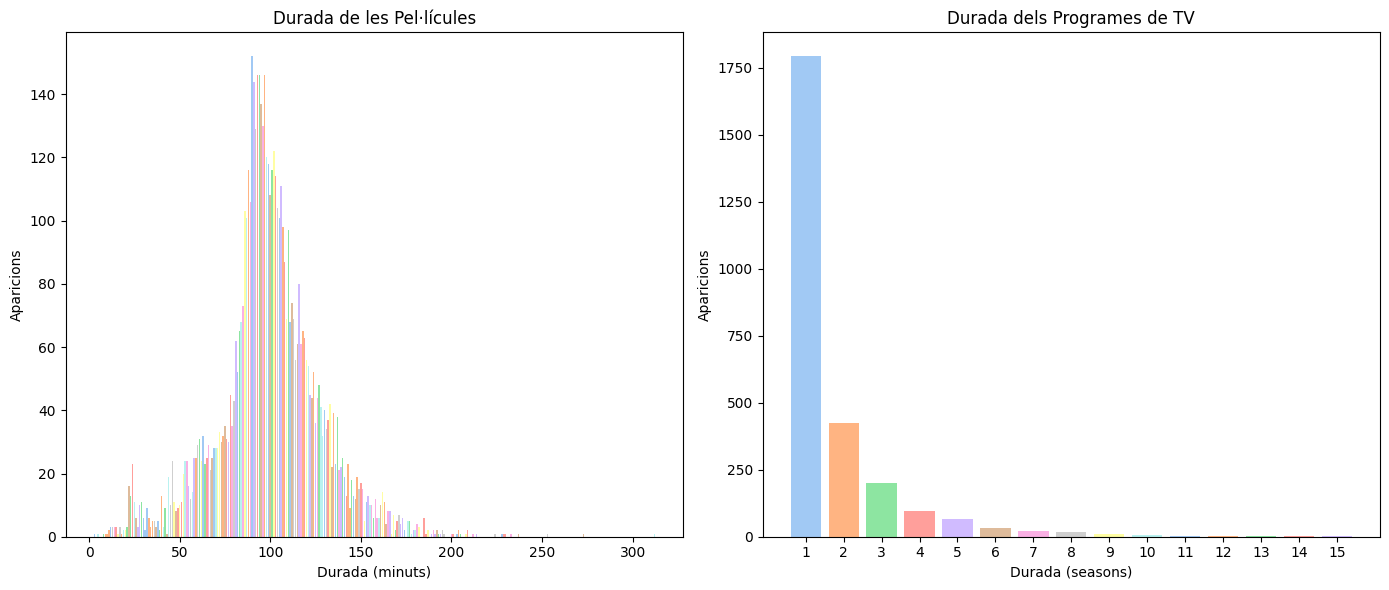

'\nmovie_df = df[df[\'type\'] == \'Movie\']\ntv_show_df = df[df[\'type\'] == \'TV Show\']\n\nmovie_duration = movie_df[\'duration\'].str.replace(\' min\', \'\').astype(int)\ntv_show_duration = tv_show_df[\'duration\'].str.replace(r\'[^0-9]\', \'\', regex=True).astype(int)\n\nmovie_duration_counts = movie_duration.value_counts()\ntv_show_duration_counts = tv_show_duration.value_counts()\n\nmovie_colors = sns.color_palette("pastel", len(movie_duration_counts))\ntv_show_colors = sns.color_palette("pastel", len(tv_show_duration_counts))\n\nfig, axes = plt.subplots(1, 2, figsize=(14, 6))\n\naxes[0].bar(movie_duration_counts.index, movie_duration_counts.values, color=movie_colors)\naxes[0].set_title("Durada de les Pel·lícules")\naxes[0].set_xlabel("Durada (minuts)")\naxes[0].set_ylabel("Aparicions")\n\ntv_show_duration_counts_sorted = tv_show_duration_counts.sort_index()  \n\naxes[1].bar(range(1, len(tv_show_duration_counts_sorted) + 1), tv_show_duration_counts_sorted.values, color=tv_show_c

In [37]:
movie_df = df[df['type'] == 'Movie'].drop_duplicates(subset=['title', 'duration'])
tv_show_df = df[df['type'] == 'TV Show'].drop_duplicates(subset=['title', 'duration'])

movie_duration = movie_df['duration'].str.replace(' min', '').astype(int)
tv_show_duration = tv_show_df['duration'].str.replace(r'[^0-9]', '', regex=True).astype(int)

movie_duration_counts = movie_duration.value_counts()
tv_show_duration_counts = tv_show_duration.value_counts()

movie_colors = sns.color_palette("pastel", len(movie_duration_counts))
tv_show_colors = sns.color_palette("pastel", len(tv_show_duration_counts))

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].bar(movie_duration_counts.index, movie_duration_counts.values, color=movie_colors)
axes[0].set_title("Durada de les Pel·lícules")
axes[0].set_xlabel("Durada (minuts)")
axes[0].set_ylabel("Aparicions")

tv_show_duration_counts_sorted = tv_show_duration_counts.sort_index()
axes[1].bar(range(1, len(tv_show_duration_counts_sorted) + 1), tv_show_duration_counts_sorted.values, color=tv_show_colors)
axes[1].set_title("Durada dels Programes de TV")
axes[1].set_xlabel("Durada (seasons)")
axes[1].set_ylabel("Aparicions")
axes[1].set_xticks(range(1, len(tv_show_duration_counts_sorted) + 1))
axes[1].set_xticklabels(range(1, len(tv_show_duration_counts_sorted) + 1))

plt.tight_layout()
plt.show()

"""
movie_df = df[df['type'] == 'Movie']
tv_show_df = df[df['type'] == 'TV Show']

movie_duration = movie_df['duration'].str.replace(' min', '').astype(int)
tv_show_duration = tv_show_df['duration'].str.replace(r'[^0-9]', '', regex=True).astype(int)

movie_duration_counts = movie_duration.value_counts()
tv_show_duration_counts = tv_show_duration.value_counts()

movie_colors = sns.color_palette("pastel", len(movie_duration_counts))
tv_show_colors = sns.color_palette("pastel", len(tv_show_duration_counts))

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].bar(movie_duration_counts.index, movie_duration_counts.values, color=movie_colors)
axes[0].set_title("Durada de les Pel·lícules")
axes[0].set_xlabel("Durada (minuts)")
axes[0].set_ylabel("Aparicions")

tv_show_duration_counts_sorted = tv_show_duration_counts.sort_index()  

axes[1].bar(range(1, len(tv_show_duration_counts_sorted) + 1), tv_show_duration_counts_sorted.values, color=tv_show_colors)
axes[1].set_title("Durada dels Programes de TV")
axes[1].set_xlabel("Durada (seasons)")
axes[1].set_ylabel("Aparicions")
axes[1].set_xticks(range(1, len(tv_show_duration_counts_sorted) + 1))
axes[1].set_xticklabels(range(1, len(tv_show_duration_counts_sorted) + 1))

plt.tight_layout()
plt.show()
"""

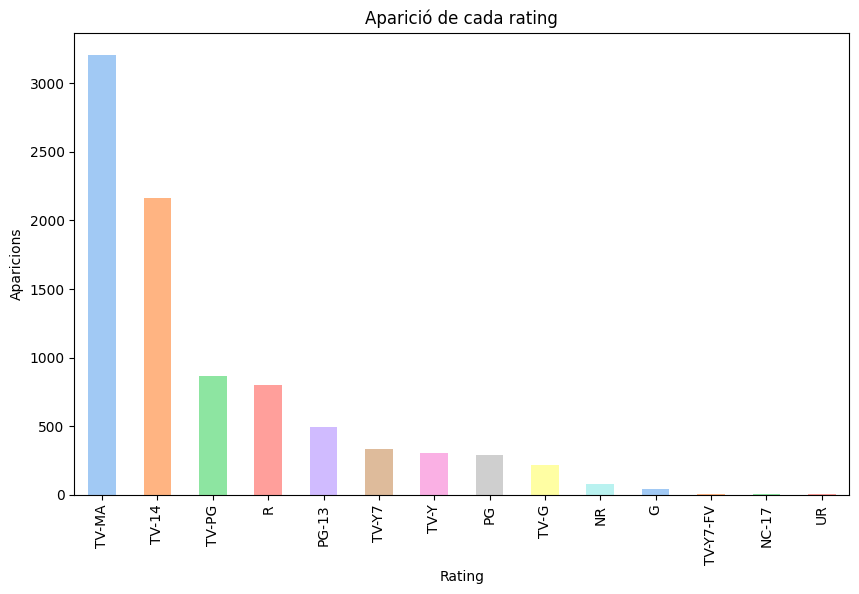

'\nratings = [genre.strip() for genres in df[\'rating\'] for genre in genres.split(\',\')]\ntype_counts = pd.Series(ratings).value_counts()\ncolors = sns.color_palette("pastel", len(type_counts))\n\nplt.figure(figsize=(10, 6))\ntype_counts.plot(kind=\'bar\', color=colors)\nplt.title("Aparició de cada rating")\nplt.xlabel("Rating")\nplt.ylabel("Aparicions")\nplt.show()\n'

In [38]:
ratings = [rating.strip() for rating in df.drop_duplicates(subset=['title', 'rating'])['rating']]
rating_counts = pd.Series(ratings).value_counts()
colors = sns.color_palette("pastel", len(rating_counts))

plt.figure(figsize=(10, 6))
rating_counts.plot(kind='bar', color=colors)
plt.title("Aparició de cada rating")
plt.xlabel("Rating")
plt.ylabel("Aparicions")
plt.show()

"""
ratings = [genre.strip() for genres in df['rating'] for genre in genres.split(',')]
type_counts = pd.Series(ratings).value_counts()
colors = sns.color_palette("pastel", len(type_counts))

plt.figure(figsize=(10, 6))
type_counts.plot(kind='bar', color=colors)
plt.title("Aparició de cada rating")
plt.xlabel("Rating")
plt.ylabel("Aparicions")
plt.show()
"""

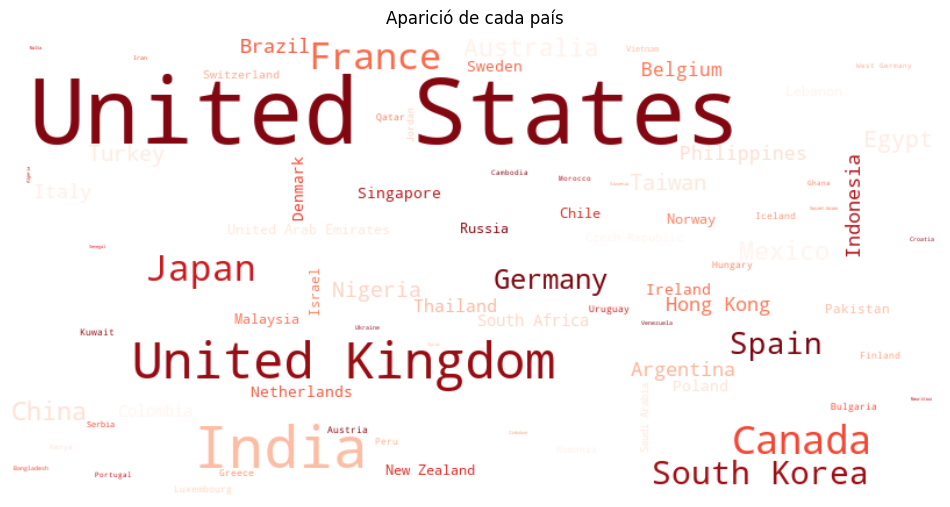

'\ncountries = [genre.strip() for genres in df[\'country\'] for genre in genres.split(\',\')]\ntype_counts = pd.Series(countries).value_counts()\n\ncountry_freq = type_counts.to_dict()\n\nplt.figure(figsize=(12, 8))\nwordcloud = WordCloud(width=800, height=400, background_color=\'white\', colormap=\'Reds\').generate_from_frequencies(country_freq)\nplt.imshow(wordcloud, interpolation=\'bilinear\')\nplt.axis(\'off\')\nplt.title("Aparició de cada país")\nplt.show()\n'

In [39]:
countries = [country.strip() for countries in df.drop_duplicates(subset=['title', 'country'])['country'] for country in countries.split(',')]
country_freq = pd.Series(countries).value_counts().to_dict()

plt.figure(figsize=(12, 8))
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate_from_frequencies(country_freq)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Aparició de cada país")
plt.show()

"""
countries = [genre.strip() for genres in df['country'] for genre in genres.split(',')]
type_counts = pd.Series(countries).value_counts()

country_freq = type_counts.to_dict()

plt.figure(figsize=(12, 8))
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate_from_frequencies(country_freq)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Aparició de cada país")
plt.show()
"""

Per corroborar que el word cloud està be, mirem quins son els actors més comuns del dataset un cop feta la predicció dels nans.

In [44]:
# Expansió de la columna 'cast' per separar els actors
actors_individuals = df['cast'].str.split(', ').explode()

# Creem un DataFrame temporal amb títol i actor
df_actors = pd.DataFrame({
    'title': df['title'].repeat(df['cast'].str.split(', ').str.len()),
    'actor': actors_individuals
})

# Eliminem duplicats per títol i actor, comptabilitzant cada actor només una vegada per pel·lícula
df_actors_unique = df_actors.drop_duplicates(subset=['title', 'actor'])

# Comptabilitzem els actors
top_10_individual_actors = df_actors_unique['actor'].value_counts().head(10)

# Mostrar el top 10
print(top_10_individual_actors)


actor
Anupam Kher         43
Shah Rukh Khan      35
Julie Tejwani       33
Takahiro Sakurai    32
Naseeruddin Shah    32
Rupa Bhimani        31
Akshay Kumar        30
Om Puri             30
Yuki Kaji           29
Amitabh Bachchan    28
Name: count, dtype: int64


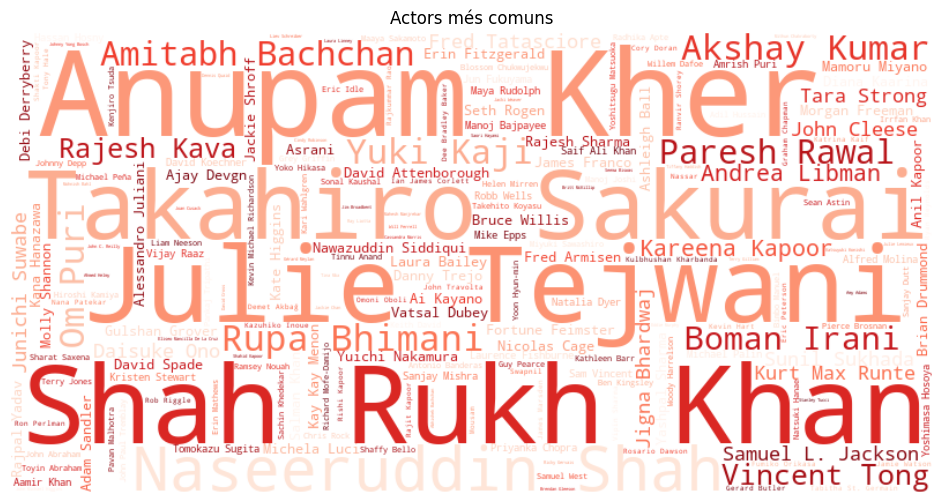

'\nactor_counts = actors_individuals.value_counts()  \nwordcloud = WordCloud(width=800, height=400, background_color=\'white\', colormap=\'Reds\').generate_from_frequencies(actor_counts)\n\nplt.figure(figsize=(12, 6))\nplt.imshow(wordcloud, interpolation=\'bilinear\')\nplt.axis(\'off\')\nplt.title("Actors més comuns")\nplt.show()\n'

In [43]:
# Eliminar duplicats per títol i 'cast' (conservar una sola entrada per títol/actor)
df_unics_cast = df.drop_duplicates(subset=['title', 'cast'])

# Expansió dels actors per cada pel·lícula/sèrie
actors = [actor.strip() for cast in df_unics_cast['cast'] for actor in cast.split(',')]
actor_counts = pd.Series(actors).value_counts()

# Graficar el WordCloud
plt.figure(figsize=(12, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate_from_frequencies(actor_counts)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Actors més comuns")
plt.show()


"""
actor_counts = actors_individuals.value_counts()  
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate_from_frequencies(actor_counts)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Actors més comuns")
plt.show()
"""

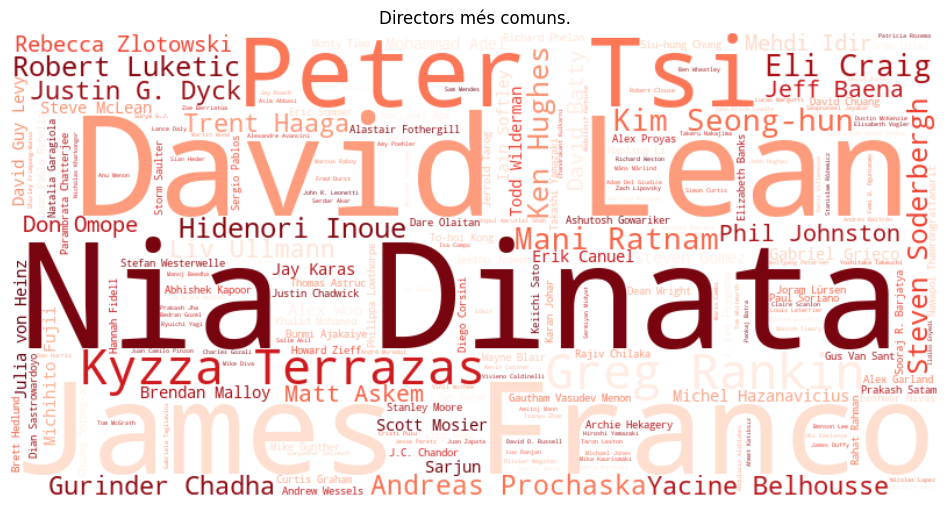

'\ndirectors = [genre.strip() for genres in df[\'director\'] for genre in genres.split(\',\')]\ntype_counts = pd.Series(directors).value_counts()\n\ndirectors_freq = type_counts.to_dict()\n\nplt.figure(figsize=(12, 8))\nwordcloud = WordCloud(width=800, height=400, background_color=\'white\', colormap=\'Reds\').generate_from_frequencies(directors_freq)\nplt.imshow(wordcloud, interpolation=\'bilinear\')\nplt.axis(\'off\')\nplt.title("Directors més comuns.")\nplt.show()\n'

In [45]:
directors = [director.strip() for directors in df.drop_duplicates(subset=['title', 'director'])['director'] for director in directors.split(',')]
director_counts = pd.Series(directors).value_counts()

plt.figure(figsize=(12, 8))
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate_from_frequencies(director_counts)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Directors més comuns.")
plt.show()

"""
directors = [genre.strip() for genres in df['director'] for genre in genres.split(',')]
type_counts = pd.Series(directors).value_counts()

directors_freq = type_counts.to_dict()

plt.figure(figsize=(12, 8))
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate_from_frequencies(directors_freq)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Directors més comuns.")
plt.show()
"""


Comprovació del WordCloud:

In [47]:
# Expansió de la columna 'cast' per separar els actors
directors_individuals = df['director'].str.split(', ').explode()

# Creem un DataFrame temporal amb títol i actor
df_directors = pd.DataFrame({
    'title': df['title'].repeat(df['director'].str.split(', ').str.len()),
    'director': directors_individuals
})

# Eliminem duplicats per títol i actor, comptabilitzant cada actor només una vegada per pel·lícula
df_directors_unique = df_directors.drop_duplicates(subset=['title', 'director'])

# Comptabilitzem els actors
top_10_individual_actors = df_directors_unique['director'].value_counts().head(10)

# Mostrar el top 10
print(top_10_individual_actors)


director
Nia Dinata        70
David Lean        62
James Franco      57
Peter Tsi         57
Kyzza Terrazas    54
Greg Rankin       54
Kim Seong-hun     53
Mani Ratnam       52
Eli Craig         50
Ken Hughes        48
Name: count, dtype: int64


### **3.4 CORRELACIÓ ENTRE ELS ATRIBUTS**

<Figure size 1500x800 with 0 Axes>

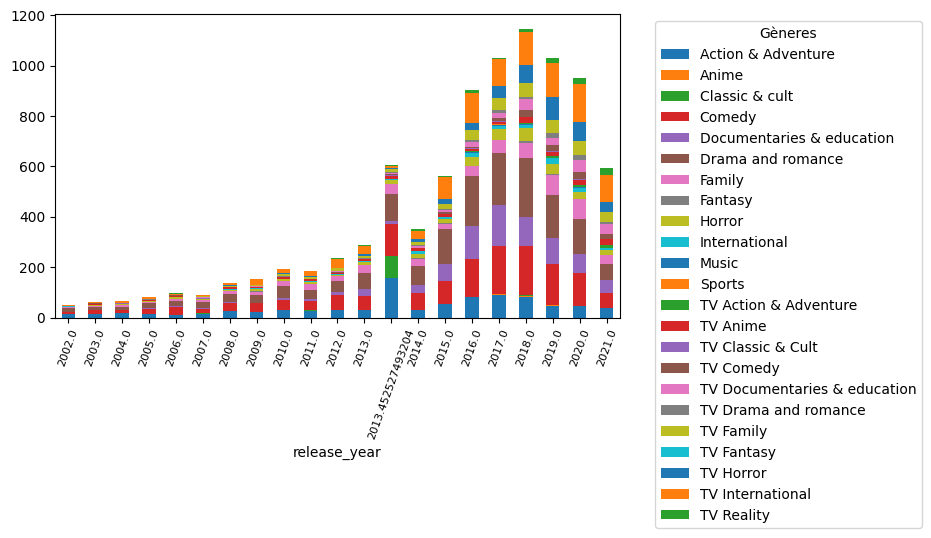

"\ntop_years = df['release_year'].value_counts().nlargest(54).index\nd_f = df[df['release_year'].isin(top_years)]\n\nd_f['release_year'] = d_f['release_year'].where(d_f['release_year'].isin(top_years), 'Other')\n\nd_f['listed_in'] = d_f['listed_in'].str.split(',').apply(lambda x: ', '.join(sorted(set(map(str.strip, x)))))\n\ndf_copia = d_f.copy()\ndf_copia = df_copia.assign(listed_in=df_copia['listed_in'].str.split(', '))\ndf_copia = df_copia.explode('listed_in')\n\ndata = df_copia.groupby(['release_year', 'listed_in']).size().unstack(fill_value=0)\n\nplt.figure(figsize=(15, 8))  \ndata.plot(kind='bar', stacked=True, legend=False)  \nplt.xticks(rotation=70, fontsize=8) \nplt.tight_layout() \n\nplt.legend(title='Gèneres', bbox_to_anchor=(1.05, 1), loc='upper left')\n\nplt.show()\n"

In [48]:
top_years = df['release_year'].value_counts().nlargest(54).index
d_f = df[df['release_year'].isin(top_years)]

# Comptabilitzar només un cop per títol i any
d_f = d_f.drop_duplicates(subset=['title', 'release_year'])

# Processament dels gèneres
d_f['listed_in'] = d_f['listed_in'].str.split(',').apply(lambda x: ', '.join(sorted(set(map(str.strip, x)))))
df_copia = d_f.copy()
df_copia = df_copia.assign(listed_in=df_copia['listed_in'].str.split(', '))
df_copia = df_copia.explode('listed_in')

# Agrupar per any i gènere
data = df_copia.groupby(['release_year', 'listed_in']).size().unstack(fill_value=0)

# Graficar
plt.figure(figsize=(15, 8))  
data.plot(kind='bar', stacked=True, legend=False)  
plt.xticks(rotation=70, fontsize=8) 
plt.tight_layout() 
plt.legend(title='Gèneres', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

"""
top_years = df['release_year'].value_counts().nlargest(54).index
d_f = df[df['release_year'].isin(top_years)]

d_f['release_year'] = d_f['release_year'].where(d_f['release_year'].isin(top_years), 'Other')

d_f['listed_in'] = d_f['listed_in'].str.split(',').apply(lambda x: ', '.join(sorted(set(map(str.strip, x)))))

df_copia = d_f.copy()
df_copia = df_copia.assign(listed_in=df_copia['listed_in'].str.split(', '))
df_copia = df_copia.explode('listed_in')

data = df_copia.groupby(['release_year', 'listed_in']).size().unstack(fill_value=0)

plt.figure(figsize=(15, 8))  
data.plot(kind='bar', stacked=True, legend=False)  
plt.xticks(rotation=70, fontsize=8) 
plt.tight_layout() 

plt.legend(title='Gèneres', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()
"""


<Figure size 1500x800 with 0 Axes>

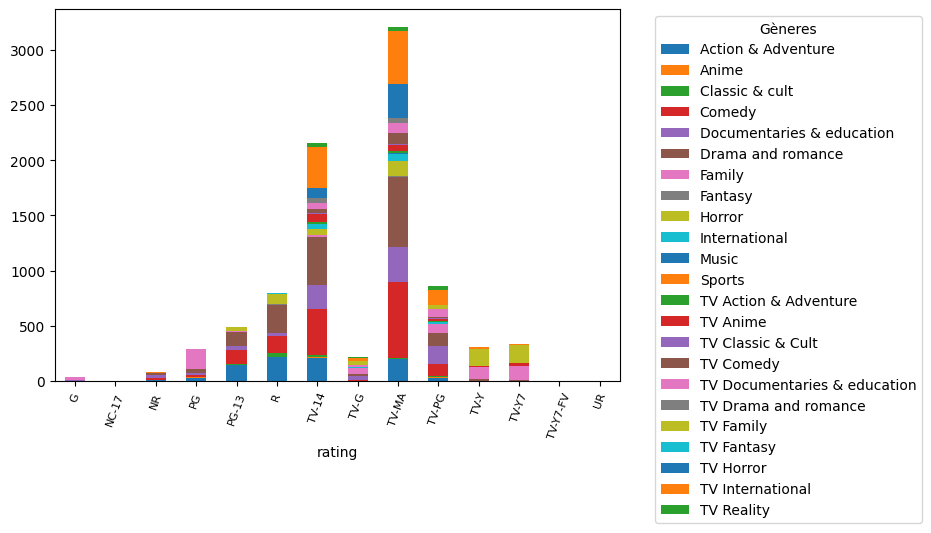

"\ntop_ratings = df['rating'].value_counts().nlargest(54).index\nd_f = df[df['rating'].isin(top_ratings)]\n\nd_f['rating'] = d_f['rating'].where(d_f['rating'].isin(top_ratings), 'Other')\n\nd_f['listed_in'] = d_f['listed_in'].str.split(',').apply(lambda x: ', '.join(sorted(set(map(str.strip, x)))))\n\ndf_copia = d_f.copy()\ndf_copia = df_copia.assign(listed_in=df_copia['listed_in'].str.split(', '))\ndf_copia = df_copia.explode('listed_in')\n\ndata = df_copia.groupby(['rating', 'listed_in']).size().unstack(fill_value=0)\n\nplt.figure(figsize=(15, 8))  \ndata.plot(kind='bar', stacked=True, legend=False)  \nplt.xticks(rotation=70, fontsize=8) \nplt.tight_layout()  \n\nplt.legend(title='Gèneres', bbox_to_anchor=(1.05, 1), loc='upper left')\n\nplt.show()\n"

In [49]:
top_ratings = df['rating'].value_counts().nlargest(54).index
d_f = df[df['rating'].isin(top_ratings)]

# Comptabilitzar només un cop per títol i rating
d_f = d_f.drop_duplicates(subset=['title', 'rating'])

# Processament dels gèneres
d_f['listed_in'] = d_f['listed_in'].str.split(',').apply(lambda x: ', '.join(sorted(set(map(str.strip, x)))))
df_copia = d_f.copy()
df_copia = df_copia.assign(listed_in=df_copia['listed_in'].str.split(', '))
df_copia = df_copia.explode('listed_in')

# Agrupar per rating i gènere
data = df_copia.groupby(['rating', 'listed_in']).size().unstack(fill_value=0)

# Graficar
plt.figure(figsize=(15, 8))  
data.plot(kind='bar', stacked=True, legend=False)  
plt.xticks(rotation=70, fontsize=8) 
plt.tight_layout()  
plt.legend(title='Gèneres', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

"""
top_ratings = df['rating'].value_counts().nlargest(54).index
d_f = df[df['rating'].isin(top_ratings)]

d_f['rating'] = d_f['rating'].where(d_f['rating'].isin(top_ratings), 'Other')

d_f['listed_in'] = d_f['listed_in'].str.split(',').apply(lambda x: ', '.join(sorted(set(map(str.strip, x)))))

df_copia = d_f.copy()
df_copia = df_copia.assign(listed_in=df_copia['listed_in'].str.split(', '))
df_copia = df_copia.explode('listed_in')

data = df_copia.groupby(['rating', 'listed_in']).size().unstack(fill_value=0)

plt.figure(figsize=(15, 8))  
data.plot(kind='bar', stacked=True, legend=False)  
plt.xticks(rotation=70, fontsize=8) 
plt.tight_layout()  

plt.legend(title='Gèneres', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()
"""

<Figure size 1500x800 with 0 Axes>

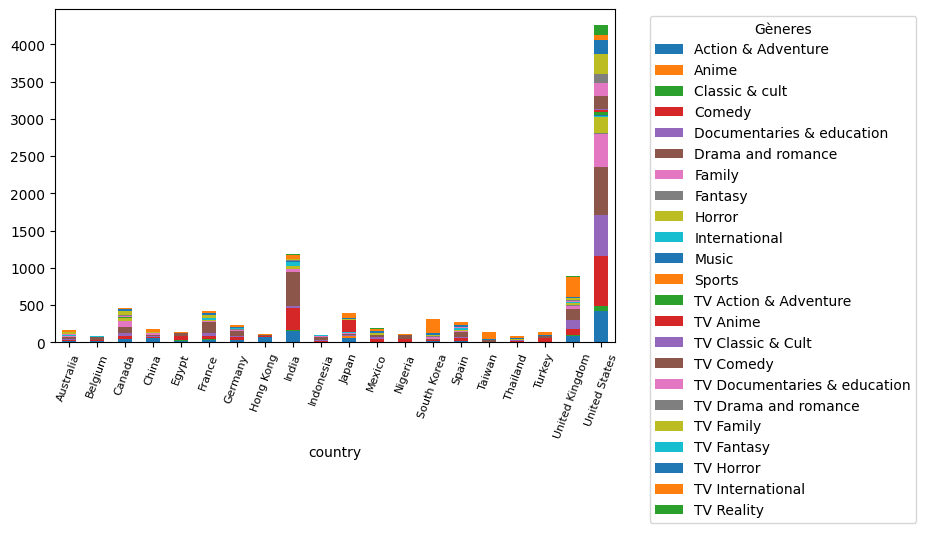

"\ntop_countries = df['country'].value_counts().nlargest(20).index\nd_f = df[df['country'].isin(top_countries)]\n\nd_f['country'] = d_f['country'].where(d_f['country'].isin(top_countries), 'Other')\nd_f['listed_in'] = d_f['listed_in'].str.split(',').apply(lambda x: ', '.join(sorted(set(map(str.strip, x)))))\n\ndf_copia = d_f.copy()\ndf_copia = df_copia.assign(country=df_copia['country'].str.split(', '))\ndf_copia = df_copia.explode('country')  \n\ndf_copia = df_copia.assign(listed_in=df_copia['listed_in'].str.split(', '))\ndf_copia = df_copia.explode('listed_in')\n\ndata = df_copia.groupby(['country', 'listed_in']).size().unstack(fill_value=0)\n\nplt.figure(figsize=(15, 8))  \ndata.plot(kind='bar', stacked=True, legend=False)  \nplt.xticks(rotation=70, fontsize=8) \nplt.tight_layout()  \nplt.legend(title='Gèneres', bbox_to_anchor=(1.05, 1), loc='upper left')\n\nplt.show()\n"

In [50]:
top_countries = df['country'].value_counts().nlargest(20).index
d_f = df[df['country'].isin(top_countries)]

# Comptabilitzar només un cop per títol i país
d_f = d_f.drop_duplicates(subset=['title', 'country'])

# Processament dels gèneres
d_f['listed_in'] = d_f['listed_in'].str.split(',').apply(lambda x: ', '.join(sorted(set(map(str.strip, x)))))
df_copia = d_f.copy()
df_copia = df_copia.assign(country=df_copia['country'].str.split(', '))
df_copia = df_copia.explode('country')  
df_copia = df_copia.assign(listed_in=df_copia['listed_in'].str.split(', '))
df_copia = df_copia.explode('listed_in')

# Agrupar per país i gènere
data = df_copia.groupby(['country', 'listed_in']).size().unstack(fill_value=0)

# Graficar
plt.figure(figsize=(15, 8))  
data.plot(kind='bar', stacked=True, legend=False)  
plt.xticks(rotation=70, fontsize=8) 
plt.tight_layout()  
plt.legend(title='Gèneres', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

"""
top_countries = df['country'].value_counts().nlargest(20).index
d_f = df[df['country'].isin(top_countries)]

d_f['country'] = d_f['country'].where(d_f['country'].isin(top_countries), 'Other')
d_f['listed_in'] = d_f['listed_in'].str.split(',').apply(lambda x: ', '.join(sorted(set(map(str.strip, x)))))

df_copia = d_f.copy()
df_copia = df_copia.assign(country=df_copia['country'].str.split(', '))
df_copia = df_copia.explode('country')  

df_copia = df_copia.assign(listed_in=df_copia['listed_in'].str.split(', '))
df_copia = df_copia.explode('listed_in')

data = df_copia.groupby(['country', 'listed_in']).size().unstack(fill_value=0)

plt.figure(figsize=(15, 8))  
data.plot(kind='bar', stacked=True, legend=False)  
plt.xticks(rotation=70, fontsize=8) 
plt.tight_layout()  
plt.legend(title='Gèneres', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()
"""


<Figure size 1500x800 with 0 Axes>

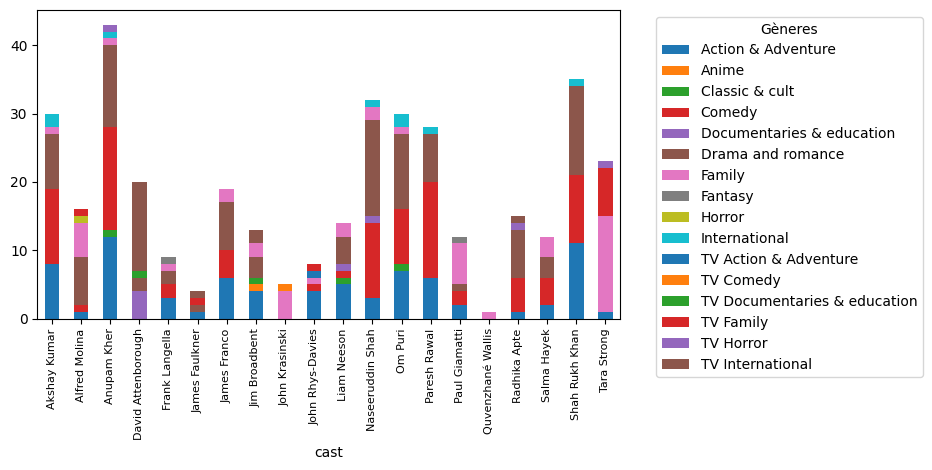

"\ntop_casts = df['cast'].dropna().str.split(', ').explode().value_counts().nlargest(20).index\n\nd_f= df[df['cast'].notna() & df['cast'].str.split(', ').apply(lambda x: any(c in top_casts for c in x))]\n\nd_f['cast'] = d_f['cast'].apply(lambda x: ', '.join([c for c in x.split(', ') if c in top_casts]))\n\nd_f['listed_in'] = d_f['listed_in'].str.split(',').apply(lambda x: ', '.join(sorted(set(map(str.strip, x)))))\n\ndf_copia = d_f.copy()\ndf_copia = df_copia.assign(cast=df_copia['cast'].str.split(', '))\ndf_copia = df_copia.explode('cast')  \n\ndf_copia = df_copia.assign(listed_in=df_copia['listed_in'].str.split(', '))\ndf_copia = df_copia.explode('listed_in')\n\ndata = df_copia.groupby(['cast', 'listed_in']).size().unstack(fill_value=0)\n\nplt.figure(figsize=(15, 8))  \ndata.plot(kind='bar', stacked=True, legend=False)  \nplt.xticks(rotation=90, fontsize=8)  \nplt.tight_layout()  \nplt.legend(title='Gèneres', bbox_to_anchor=(1.05, 1), loc='upper left')\n\nplt.show()\n"

In [51]:
top_casts = df['cast'].dropna().str.split(', ').explode().value_counts().nlargest(20).index
d_f = df[df['cast'].notna() & df['cast'].str.split(', ').apply(lambda x: any(c in top_casts for c in x))]

# Comptabilitzar només un cop per títol i actor
d_f = d_f.drop_duplicates(subset=['title', 'cast'])

# Processament dels gèneres
d_f['cast'] = d_f['cast'].apply(lambda x: ', '.join([c for c in x.split(', ') if c in top_casts]))
d_f['listed_in'] = d_f['listed_in'].str.split(',').apply(lambda x: ', '.join(sorted(set(map(str.strip, x)))))
df_copia = d_f.copy()
df_copia = df_copia.assign(cast=df_copia['cast'].str.split(', '))
df_copia = df_copia.explode('cast')  
df_copia = df_copia.assign(listed_in=df_copia['listed_in'].str.split(', '))
df_copia = df_copia.explode('listed_in')

# Agrupar per actor i gènere
data = df_copia.groupby(['cast', 'listed_in']).size().unstack(fill_value=0)

# Graficar
plt.figure(figsize=(15, 8))  
data.plot(kind='bar', stacked=True, legend=False)  
plt.xticks(rotation=90, fontsize=8)  
plt.tight_layout()  
plt.legend(title='Gèneres', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

"""
top_casts = df['cast'].dropna().str.split(', ').explode().value_counts().nlargest(20).index

d_f= df[df['cast'].notna() & df['cast'].str.split(', ').apply(lambda x: any(c in top_casts for c in x))]

d_f['cast'] = d_f['cast'].apply(lambda x: ', '.join([c for c in x.split(', ') if c in top_casts]))

d_f['listed_in'] = d_f['listed_in'].str.split(',').apply(lambda x: ', '.join(sorted(set(map(str.strip, x)))))

df_copia = d_f.copy()
df_copia = df_copia.assign(cast=df_copia['cast'].str.split(', '))
df_copia = df_copia.explode('cast')  

df_copia = df_copia.assign(listed_in=df_copia['listed_in'].str.split(', '))
df_copia = df_copia.explode('listed_in')

data = df_copia.groupby(['cast', 'listed_in']).size().unstack(fill_value=0)

plt.figure(figsize=(15, 8))  
data.plot(kind='bar', stacked=True, legend=False)  
plt.xticks(rotation=90, fontsize=8)  
plt.tight_layout()  
plt.legend(title='Gèneres', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()
"""


<Figure size 1500x800 with 0 Axes>

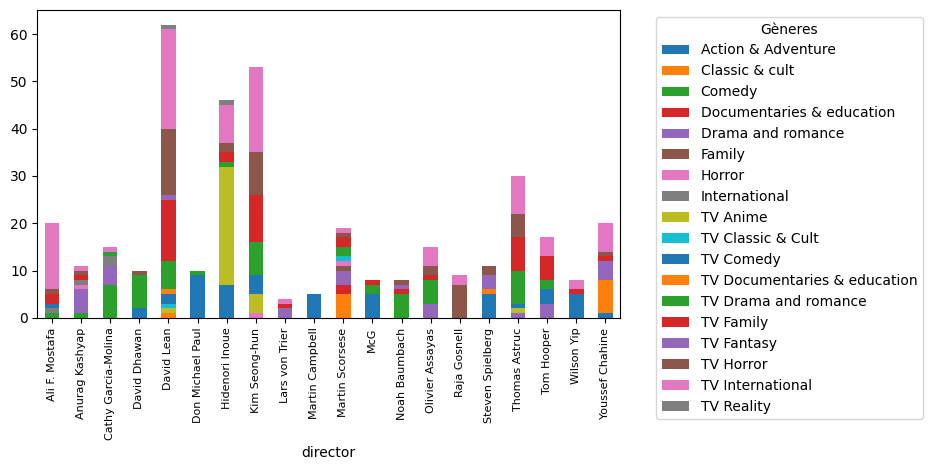

"\ntop_directors = df['director'].dropna().str.split(', ').explode().value_counts().nlargest(20).index\n\nd_f = df[df['director'].notna() & df['director'].str.split(', ').apply(lambda x: any(d in top_directors for d in x))]\n\nd_f['director'] = d_f['director'].apply(lambda x: ', '.join([d for d in x.split(', ') if d in top_directors]))\n\nd_f['listed_in'] = d_f['listed_in'].str.split(',').apply(lambda x: ', '.join(sorted(set(map(str.strip, x)))))\n\ndf_copia = d_f.copy()\ndf_copia = df_copia.assign(director=df_copia['director'].str.split(', '))\ndf_copia = df_copia.explode('director')\n\ndf_copia = df_copia[df_copia['director'].isin(top_directors)]\n\ndf_copia = df_copia.assign(listed_in=df_copia['listed_in'].str.split(', '))\ndf_copia = df_copia.explode('listed_in')\n\n\ndata = df_copia.groupby(['director', 'listed_in']).size().unstack(fill_value=0)\n\nplt.figure(figsize=(15, 8)) \ndata.plot(kind='bar', stacked=True, legend=False)  \nplt.xticks(rotation=90, fontsize=8)  \nplt.tight_la

In [52]:
top_directors = df['director'].dropna().str.split(', ').explode().value_counts().nlargest(20).index
d_f = df[df['director'].notna() & df['director'].str.split(', ').apply(lambda x: any(d in top_directors for d in x))]

# Comptabilitzar només un cop per títol i director
d_f = d_f.drop_duplicates(subset=['title', 'director'])

# Processament dels gèneres
d_f['director'] = d_f['director'].apply(lambda x: ', '.join([d for d in x.split(', ') if d in top_directors]))
d_f['listed_in'] = d_f['listed_in'].str.split(',').apply(lambda x: ', '.join(sorted(set(map(str.strip, x)))))
df_copia = d_f.copy()
df_copia = df_copia.assign(director=df_copia['director'].str.split(', '))
df_copia = df_copia.explode('director')
df_copia = df_copia[df_copia['director'].isin(top_directors)]
df_copia = df_copia.assign(listed_in=df_copia['listed_in'].str.split(', '))
df_copia = df_copia.explode('listed_in')

# Agrupar per director i gènere
data = df_copia.groupby(['director', 'listed_in']).size().unstack(fill_value=0)

# Graficar
plt.figure(figsize=(15, 8)) 
data.plot(kind='bar', stacked=True, legend=False)  
plt.xticks(rotation=90, fontsize=8)  
plt.tight_layout()  
plt.legend(title='Gèneres', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

"""
top_directors = df['director'].dropna().str.split(', ').explode().value_counts().nlargest(20).index

d_f = df[df['director'].notna() & df['director'].str.split(', ').apply(lambda x: any(d in top_directors for d in x))]

d_f['director'] = d_f['director'].apply(lambda x: ', '.join([d for d in x.split(', ') if d in top_directors]))

d_f['listed_in'] = d_f['listed_in'].str.split(',').apply(lambda x: ', '.join(sorted(set(map(str.strip, x)))))

df_copia = d_f.copy()
df_copia = df_copia.assign(director=df_copia['director'].str.split(', '))
df_copia = df_copia.explode('director')

df_copia = df_copia[df_copia['director'].isin(top_directors)]

df_copia = df_copia.assign(listed_in=df_copia['listed_in'].str.split(', '))
df_copia = df_copia.explode('listed_in')


data = df_copia.groupby(['director', 'listed_in']).size().unstack(fill_value=0)

plt.figure(figsize=(15, 8)) 
data.plot(kind='bar', stacked=True, legend=False)  
plt.xticks(rotation=90, fontsize=8)  
plt.tight_layout()  


plt.legend(title='Gèneres', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()
"""


<Figure size 1500x800 with 0 Axes>

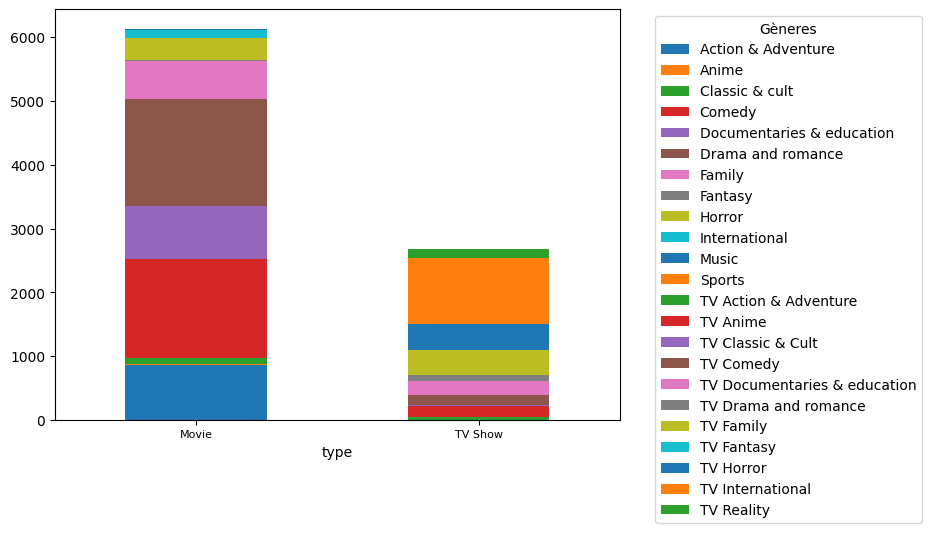

"\ntypes = df['type'].value_counts().nlargest(54).index\nd_f = df[df['type'].isin(types)]\n\nd_f['type'] = d_f['type'].where(d_f['type'].isin(types), 'Other')\n\nd_f['listed_in'] = d_f['listed_in'].str.split(',').apply(lambda x: ', '.join(sorted(set(map(str.strip, x)))))\n\ndf_copia = d_f.copy()\ndf_copia = df_copia.assign(listed_in=df_copia['listed_in'].str.split(', '))\ndf_copia = df_copia.explode('listed_in')\n\ndata = df_copia.groupby(['type', 'listed_in']).size().unstack(fill_value=0)\n\nplt.figure(figsize=(15, 8)) \ndata.plot(kind='bar', stacked=True, legend=False) \nplt.xticks(rotation=0, fontsize=8)  \nplt.tight_layout()  \n\nplt.legend(title='Gèneres', bbox_to_anchor=(1.05, 1), loc='upper left')\n\nplt.show()\n"

In [53]:
types = df['type'].value_counts().nlargest(54).index
d_f = df[df['type'].isin(types)]

# Comptabilitzar només un cop per títol i tipus
d_f = d_f.drop_duplicates(subset=['title', 'type'])

# Processament dels gèneres
d_f['listed_in'] = d_f['listed_in'].str.split(',').apply(lambda x: ', '.join(sorted(set(map(str.strip, x)))))
df_copia = d_f.copy()
df_copia = df_copia.assign(listed_in=df_copia['listed_in'].str.split(', '))
df_copia = df_copia.explode('listed_in')

# Agrupar per tipus i gènere
data = df_copia.groupby(['type', 'listed_in']).size().unstack(fill_value=0)

# Graficar
plt.figure(figsize=(15, 8)) 
data.plot(kind='bar', stacked=True, legend=False) 
plt.xticks(rotation=0, fontsize=8)  
plt.tight_layout()  
plt.legend(title='Gèneres', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

"""
types = df['type'].value_counts().nlargest(54).index
d_f = df[df['type'].isin(types)]

d_f['type'] = d_f['type'].where(d_f['type'].isin(types), 'Other')

d_f['listed_in'] = d_f['listed_in'].str.split(',').apply(lambda x: ', '.join(sorted(set(map(str.strip, x)))))

df_copia = d_f.copy()
df_copia = df_copia.assign(listed_in=df_copia['listed_in'].str.split(', '))
df_copia = df_copia.explode('listed_in')

data = df_copia.groupby(['type', 'listed_in']).size().unstack(fill_value=0)

plt.figure(figsize=(15, 8)) 
data.plot(kind='bar', stacked=True, legend=False) 
plt.xticks(rotation=0, fontsize=8)  
plt.tight_layout()  

plt.legend(title='Gèneres', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()
"""

### **3.2 ENCODING**

Les variables categòriques que volem convertir a numèriques són les següents:**Type**, **Rating**, **title,director,cast,country, listed_in,description**. 
Observem quants valors únics tenim per saber com tractar-les. 

Una vegada observats el nombre de valors únics de cada atributs prenem les desicions següents.

* Apliquem **LabelEncoder** per **type**
* Apliquem **OneHotEncoder** per **rating i listed_in**
* Apliquem **Random Category Encoding** per **director, cast i country**
* Apliquem **Bag of Words** per **description i title**
* Categorical naive bayesian

In [12]:

columns_of_interest = ['type', 'rating', 'title', 'director', 'cast', 'country', 'listed_in', 'description']
unique_values = df[columns_of_interest].nunique()
print(unique_values)


type               2
rating            14
title           8807
director        4993
cast           36439
country          122
listed_in         23
description     8775
dtype: int64


In [87]:
label_encoder_type = LabelEncoder()
df['type'] = label_encoder_type.fit_transform(df['type'])
print("Type codificat:\n", df['type'])


Type codificat:
 0         0
1         1
2         1
3         1
4         1
         ..
201954    0
201955    0
201956    0
201957    0
201958    0
Name: type, Length: 201959, dtype: int32


In [88]:
columns_to_encode = ['rating', 'listed_in']

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_data = encoder.fit_transform(df[columns_to_encode])
encoded_columns = encoder.get_feature_names_out(columns_to_encode)
encoded_df = pd.DataFrame(encoded_data, columns=encoded_columns, index=df.index)

df = pd.concat([df, encoded_df], axis=1)
print(df.head())

   type                 title         director            cast        country  \
0     0  Dick Johnson Is Dead  Kirsten Johnson  Cody Merridith  United States   
1     1         Blood & Water    Leung Lok Man      Ama Qamata   South Africa   
2     1         Blood & Water    Leung Lok Man      Ama Qamata   South Africa   
3     1         Blood & Water    Leung Lok Man      Ama Qamata   South Africa   
4     1         Blood & Water     Suseenthiran     Khosi Ngema   South Africa   

  release_year rating   duration                  listed_in  \
0         2020  PG-13     90 min  Documentaries & education   
1         2021  TV-MA  2 Seasons           TV International   
2         2021  TV-MA  2 Seasons       TV Drama and romance   
3         2021  TV-MA  2 Seasons                  TV Horror   
4         2021  TV-MA  2 Seasons           TV International   

                                         description  ...  listed_in_TV Anime  \
0  As her father nears the end of his life, filmm... 

In [15]:
print(df.columns)

Index(['type', 'title', 'director', 'cast', 'country', 'release_year',
       'rating', 'duration', 'listed_in', 'description', 'rating_G',
       'rating_NC-17', 'rating_NR', 'rating_PG', 'rating_PG-13', 'rating_R',
       'rating_TV-14', 'rating_TV-G', 'rating_TV-MA', 'rating_TV-PG',
       'rating_TV-Y', 'rating_TV-Y7', 'rating_TV-Y7-FV', 'rating_UR',
       'listed_in_Action & Adventure', 'listed_in_Anime',
       'listed_in_Classic & cult', 'listed_in_Comedy',
       'listed_in_Documentaries & education', 'listed_in_Drama and romance',
       'listed_in_Family', 'listed_in_Fantasy', 'listed_in_Horror',
       'listed_in_International', 'listed_in_Music', 'listed_in_Sports',
       'listed_in_TV Action & Adventure', 'listed_in_TV Anime',
       'listed_in_TV Classic & Cult', 'listed_in_TV Comedy',
       'listed_in_TV Documentaries & education',
       'listed_in_TV Drama and romance', 'listed_in_TV Family',
       'listed_in_TV Fantasy', 'listed_in_TV Horror',
       'listed_in_TV

In [89]:
# Funció per assignar valors únics a actors (o altres categories)
print(df[['cast']].head())
print(df[['director']].head())
print(df[['country']].head())

def map_categorical_to_numeric(df, column):
    # Obtenir els valors únics de la columna
    unique_values = df[column].unique()
    
    # Assignar un valor aleatori (o seqüencial) a cada valor únic
    random_mapping = {val: np.random.randint(1000, 9999) for val in unique_values}
    
    # Substituir els valors originals per aquests valors aleatoris
    df[column] = df[column].map(random_mapping)
    
    return df

# Assignar valors únics a la columna 'cast'
df = map_categorical_to_numeric(df, 'cast')
df = map_categorical_to_numeric(df, 'director')
df = map_categorical_to_numeric(df, 'country')

# Mostrar els resultats
print(df[['cast']].head())
print(df[['director']].head())
print(df[['country']].head())


             cast
0  Cody Merridith
1      Ama Qamata
2      Ama Qamata
3      Ama Qamata
4     Khosi Ngema
          director
0  Kirsten Johnson
1    Leung Lok Man
2    Leung Lok Man
3    Leung Lok Man
4     Suseenthiran
         country
0  United States
1   South Africa
2   South Africa
3   South Africa
4   South Africa
   cast
0  7697
1  7486
2  7486
3  7486
4  7569
   director
0      8672
1      1322
2      1322
3      1322
4      8427
   country
0     8005
1     5554
2     5554
3     5554
4     5554


In [90]:
# Descarregar les stopwords de nltk
nltk.download('stopwords')

# Imprimir els valors abans de la transformació
print("Abans de la transformació:")
print(df['title'].head())
print(df['description'].head())

# Obtenir les stopwords en anglès i espanyol
english_stop_words = text.ENGLISH_STOP_WORDS
spanish_stop_words = stopwords.words('spanish')

# Combinar les stopwords
combined_stop_words = list(set(english_stop_words).union(set(spanish_stop_words)))

# Patró personalitzat per a tokenitzar
custom_token_pattern = r'(?u)\b[A-Za-z][A-Za-z0-9]+\b'

# Vectoritzador per a la columna 'title'
vectorizer_title = CountVectorizer(stop_words=combined_stop_words, token_pattern=custom_token_pattern, max_features=20)

# Vectoritzador per a la columna 'description'
vectorizer_description = CountVectorizer(stop_words=combined_stop_words, token_pattern=custom_token_pattern, max_features=20)

# Transformar les columnes per separat
word_counts_title = vectorizer_title.fit_transform(df['title'])
word_counts_description = vectorizer_description.fit_transform(df['description'])

# Convertir els resultats a DataFrames
word_counts_df_title = pd.DataFrame(word_counts_title.toarray(), columns=vectorizer_title.get_feature_names_out())
word_counts_df_description = pd.DataFrame(word_counts_description.toarray(), columns=vectorizer_description.get_feature_names_out())

word_freq = word_counts_df_title.sum().sort_values(ascending=False)
word_freq_1 = word_counts_df_description.sum().sort_values(ascending=False)
# Eliminar les columnes originals
#df = df.drop(columns=['title', 'description'])

# Afegir els nous DataFrames al DataFrame original
df = pd.concat([df, word_counts_df_title], axis=1)
df = pd.concat([df, word_counts_df_description], axis=1)

# Mostrar els resultats
print("Després de la transformació:")
print(df.head())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Abans de la transformació:
0    Dick Johnson Is Dead
1           Blood & Water
2           Blood & Water
3           Blood & Water
4           Blood & Water
Name: title, dtype: object
0    As her father nears the end of his life, filmm...
1    After crossing paths at a party, a Cape Town t...
2    After crossing paths at a party, a Cape Town t...
3    After crossing paths at a party, a Cape Town t...
4    After crossing paths at a party, a Cape Town t...
Name: description, dtype: object
Després de la transformació:
   type                 title  director  cast  country release_year rating  \
0     0  Dick Johnson Is Dead      8672  7697     8005         2020  PG-13   
1     1         Blood & Water      1322  7486     5554         2021  TV-MA   
2     1         Blood & Water      1322  7486     5554         2021  TV-MA   
3     1         Blood & Water      1322  7486     5554         2021  TV-MA   
4     1         Blood & Water      8427  7569     5554         2021  TV-MA   

    durati

In [63]:
print('20 més freqüents de title')
print(word_freq.head(20))

20 més freqüents de title
love         3870
movie        2604
man          2021
life         1743
christmas    1650
world        1598
black        1581
girl         1436
day          1384
king         1361
story        1247
time         1223
high         1206
little       1203
boy          1123
house        1116
girls        1028
city         1010
american      926
good          879
dtype: int64


In [64]:
print('20 més freqüents de description')
print(word_freq_1.head(20))

20 més freqüents de description
young      20022
life       17905
new        16505
family     15789
man        13004
woman      12897
love       12793
world      12361
friends     8912
school      8602
finds       8031
home        7966
series      7704
high        7588
father      7509
old         7492
girl        7415
teen        6701
help        6542
group       6488
dtype: int64


In [45]:
print(df.columns)

Index(['type', 'title', 'director', 'cast', 'country', 'release_year',
       'rating', 'duration', 'listed_in', 'description', 'rating_G',
       'rating_NC-17', 'rating_NR', 'rating_PG', 'rating_PG-13', 'rating_R',
       'rating_TV-14', 'rating_TV-G', 'rating_TV-MA', 'rating_TV-PG',
       'rating_TV-Y', 'rating_TV-Y7', 'rating_TV-Y7-FV', 'rating_UR',
       'listed_in_Action & Adventure', 'listed_in_Anime',
       'listed_in_Classic & cult', 'listed_in_Comedy',
       'listed_in_Documentaries & education', 'listed_in_Drama and romance',
       'listed_in_Family', 'listed_in_Fantasy', 'listed_in_Horror',
       'listed_in_International', 'listed_in_Music', 'listed_in_Sports',
       'listed_in_TV Action & Adventure', 'listed_in_TV Anime',
       'listed_in_TV Classic & Cult', 'listed_in_TV Comedy',
       'listed_in_TV Documentaries & education',
       'listed_in_TV Drama and romance', 'listed_in_TV Family',
       'listed_in_TV Fantasy', 'listed_in_TV Horror',
       'listed_in_TV

Un cop hem obtingut les paraules més freqüents de *title* i *description*, volem comprovar si hi ha relació entre aquestes paraules i el *listed_in* per tal de saber si ens podem beneficiar d'aquesta correlació a l'hora de la classificació.

C:\Users\USER\AppData\Local\Temp\ipykernel_5484\1844394282.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_words_df['listed_in'] = df['listed_in']


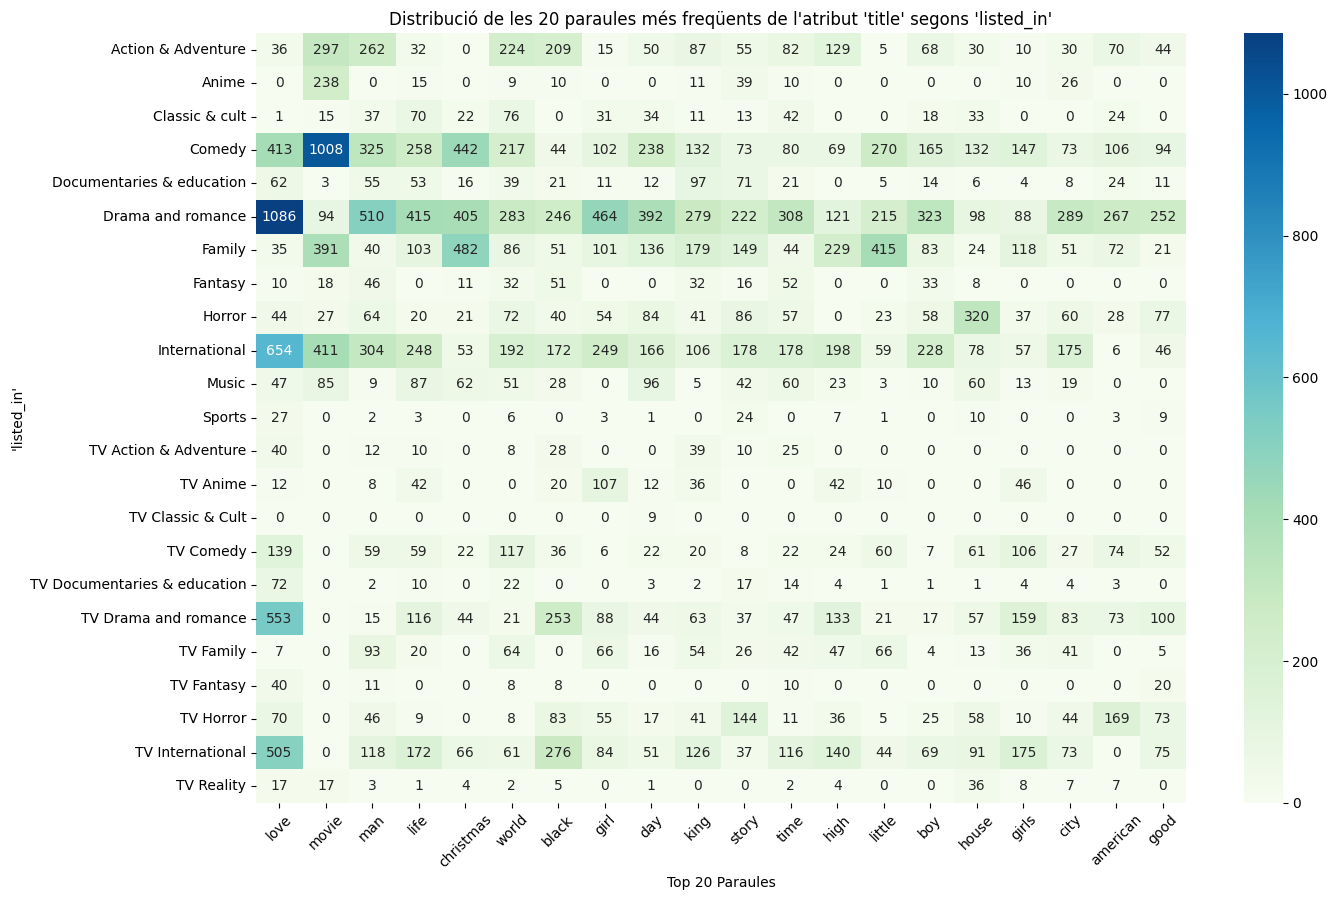

In [21]:
top_20_title = word_freq.head(20).index
top_words_df = word_counts_df_title[top_20_title]
top_words_df.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)

top_words_df['listed_in'] = df['listed_in']

top_words_freq = top_words_df.groupby('listed_in').sum()


plt.figure(figsize=(15, 10))
sns.heatmap(top_words_freq, annot=True, fmt="g", cmap="GnBu")
plt.title("Distribució de les 20 paraules més freqüents de l'atribut 'title' segons 'listed_in'")
plt.xlabel("Top 20 Paraules")
plt.ylabel("'listed_in'")
plt.xticks(rotation=45)
plt.show()


C:\Users\USER\AppData\Local\Temp\ipykernel_5484\4016277761.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_words_description_df['listed_in'] = df['listed_in']


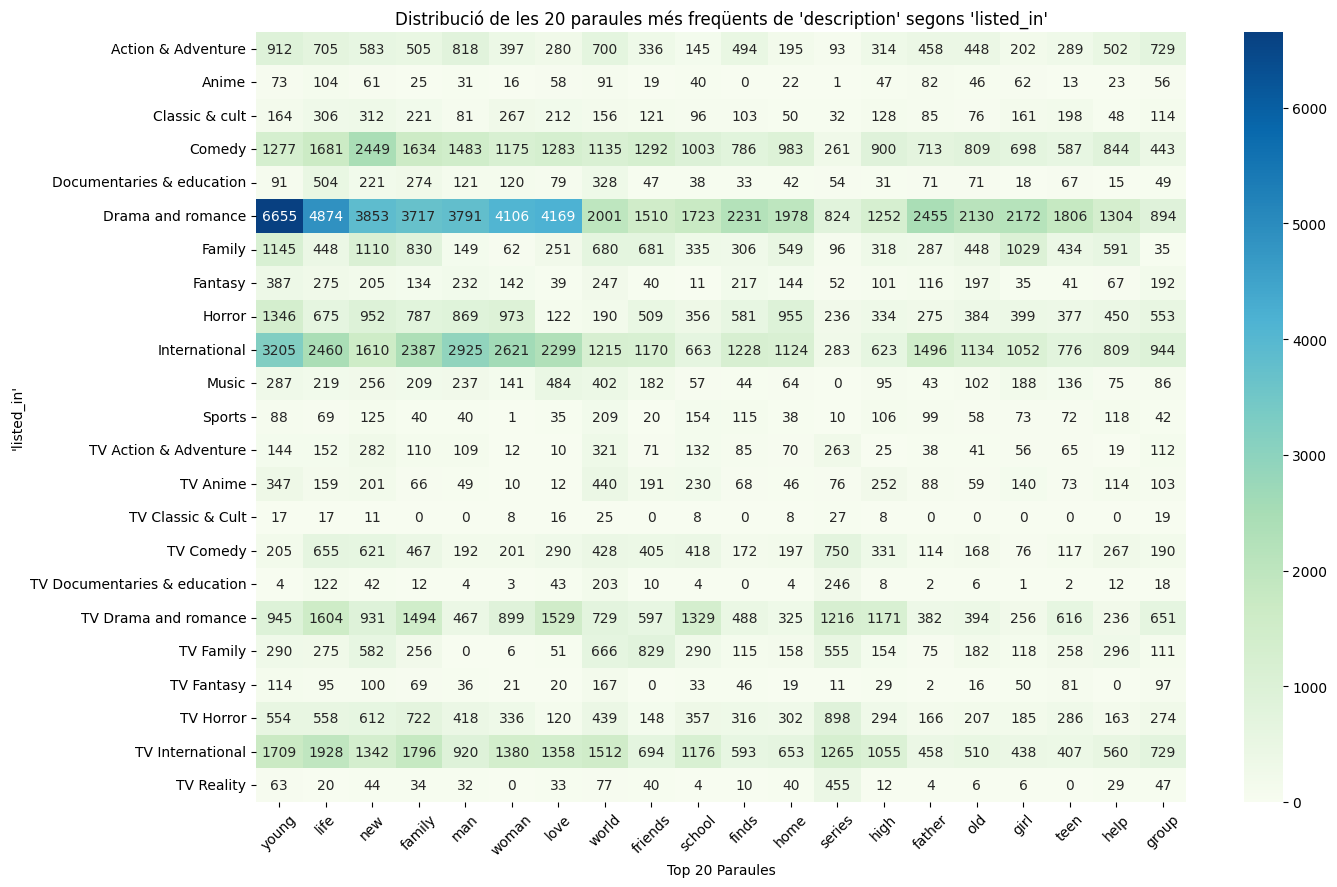

In [22]:

top_20_description = word_freq_1.head(20).index
top_words_description_df = word_counts_df_description[top_20_description]
top_words_description_df.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)

top_words_description_df['listed_in'] = df['listed_in']
top_words_freq_description = top_words_description_df.groupby('listed_in').sum()

plt.figure(figsize=(15, 10))
sns.heatmap(top_words_freq_description, annot=True, fmt="g", cmap="GnBu")
plt.title("Distribució de les 20 paraules més freqüents de 'description' segons 'listed_in'")
plt.xlabel("Top 20 Paraules")
plt.ylabel("'listed_in'")
plt.xticks(rotation=45)
plt.show()


Observem doncs que hi ha patrons evidents entre les paraules i l'atribut *listed_in*. 

Un cop passats tots els atributs a valors numèrics. Visualitzem la matriu de correlació per observar les relacions entre els atributs. 


In [91]:
df['duration'] = df['duration'].str.replace(r'[^0-9]', '', regex=True).astype(int)

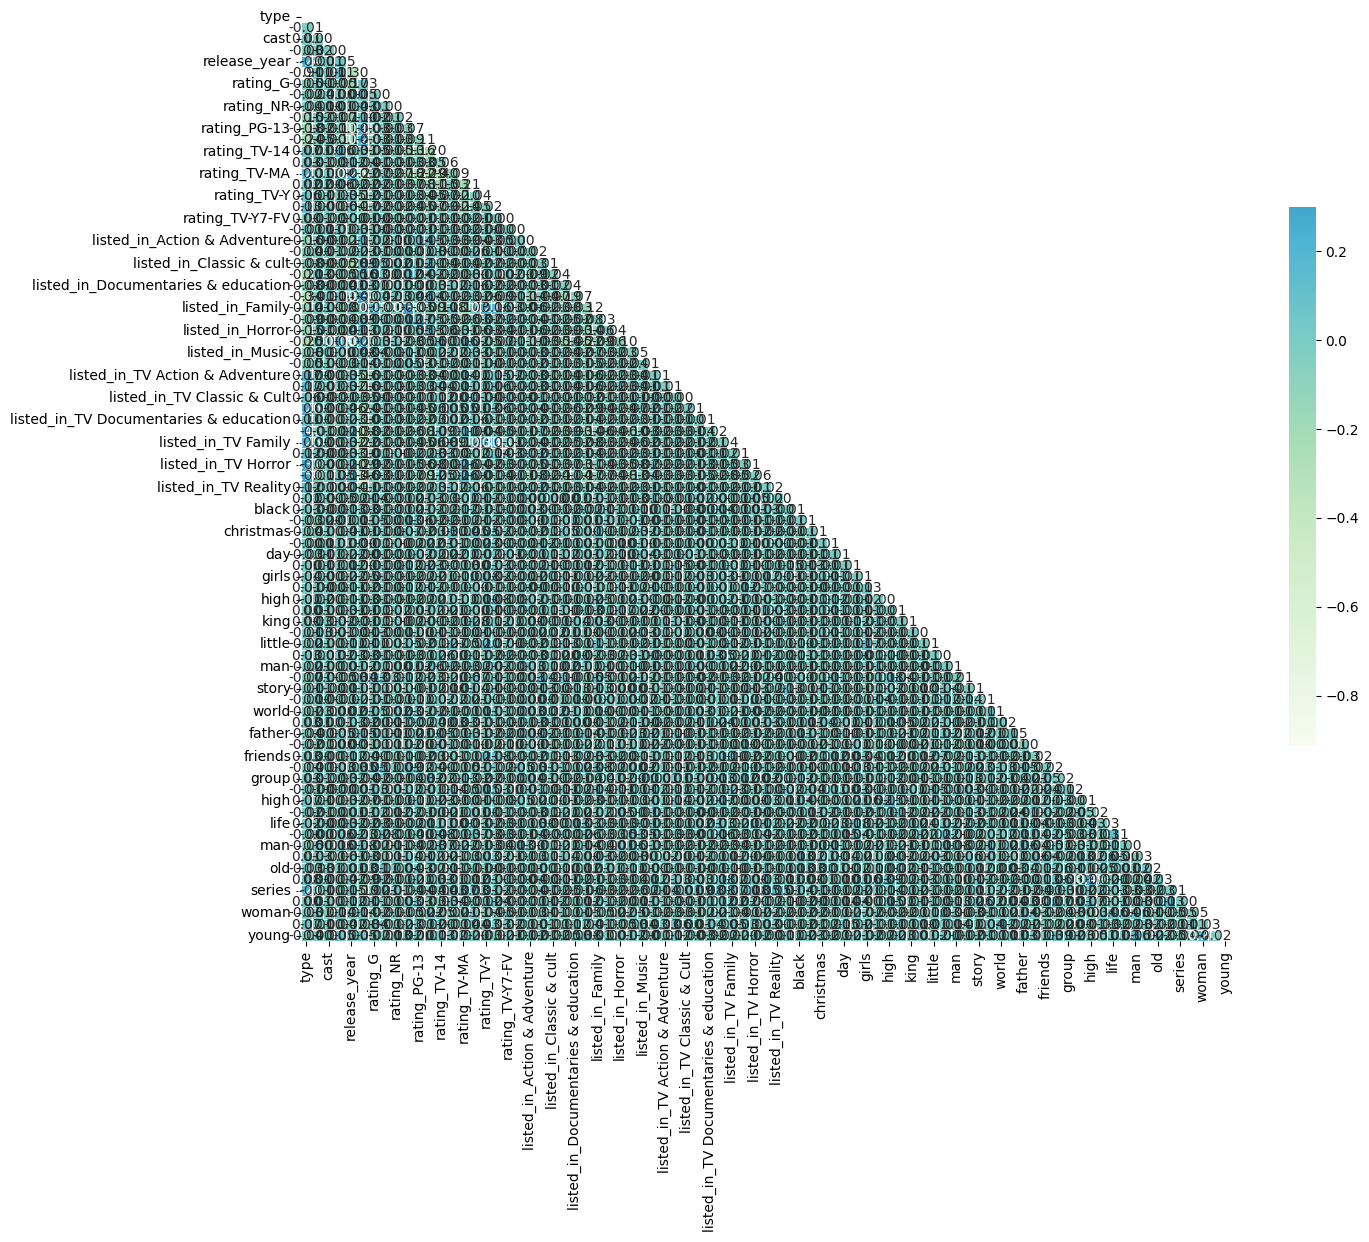

In [25]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Elimina les columnes 'listed_in' i 'rating'
df_10 = df.drop(columns=['listed_in', 'rating'])

# Calcula la matriu de correlació
corr = df_10.corr()

# Crea la màscara per a la matriu triangular superior
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Genera el mapa de calor
f, ax = plt.subplots(figsize=(15, 14))
sns.heatmap(
    corr,
    mask=mask,
    cmap='GnBu',
    vmax=.3,
    annot=True,
    center=0,
    square=True,
    fmt=".2f",
    linewidths=.5,
    cbar_kws={"shrink": .5}
)
plt.show()


### **CLASSIFICACIÓ**

Abans de la classificació, hem d'aplicar un balanceig del nostre target, ja que està molt desbalancejat i per tant, aquest desequilibri pot provocar que el model es concentri més en predir correctament els gèneres majoritaris i ignori els minoritaris.

# **4. METRIC SELECTION**

Com que hem equilibrat el nostre conjunt de dades utilitzant oversampling, hem de tenir cura amb mètriques que poden ser excessivament optimistes en dades sintètiques, com ara l'**accuracy**.

L'**F1 score** és una bona opció. Les curves de **precision-recall** també són molt útils quan es treballa amb conjunts de dades desbalancejats, ja que se centren en el rendiment de la classe positiva.

### **FEATURE SELECTION**

* OneHotEncoded: SelectKBest amb chi-squared o Random Forest. 
* LabelEncoded: SelectKBest amb Mutual Information o models basats en arbres com Random Forest, que poden manejar bé la naturalesa d'aquestes variables.

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2
from sklearn.feature_selection import RFE
from sklearn.naive_bayes import CategoricalNB
import numpy as np
from sklearn.model_selection import train_test_split


listed_ins = ['listed_in_Action & Adventure', 'listed_in_Anime', 'listed_in_Classic & cult', 
              'listed_in_Comedy', 'listed_in_Documentaries & education', 'listed_in_Drama and romance',
              'listed_in_Family', 'listed_in_Fantasy', 'listed_in_Horror', 'listed_in_International', 
              'listed_in_Music', 'listed_in_Sports', 'listed_in_TV Action & Adventure', 
              'listed_in_TV Anime', 'listed_in_TV Classic & Cult', 'listed_in_TV Comedy',
              'listed_in_TV Documentaries & education', 'listed_in_TV Drama and romance', 
              'listed_in_TV Family', 'listed_in_TV Fantasy', 'listed_in_TV Horror', 
              'listed_in_TV International', 'listed_in_TV Reality']


# Característiques (X) i etiqueta (y)
X = df.drop(columns=listed_ins + ['listed_in', 'rating', 'title', 'description', 'classified_genres'])  # Característiques
y = df[listed_ins]  # Etiqueta (gèneres per cada mostra)

# Dividir el conjunt de dades en entrenament i test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Diccionari per emmagatzemar les característiques seleccionades per cada gènere
selected_features = {}
dropped_features = {}

# Iterar per cada gènere
for genre in listed_ins:
    y_single = y_train[genre]  # Tractar cada columna com una variable objectiu independent
    
    # Selecció amb Mutual Information (per a variables contínues o ordinals)
    selector_mutual_info = SelectKBest(mutual_info_classif, k="all")
    selector_mutual_info.fit(X_train, y_single)
    
    # Selecció amb Chi-Squared (per a variables categòriques codificades, OneHotEncoded)
    selector_chi2 = SelectKBest(chi2, k="all")
    selector_chi2.fit(X_train, y_single)
    
    # Obtenir les puntuacions d'importància de cada característica
    feature_scores_mutual_info = selector_mutual_info.scores_
    feature_scores_chi2 = selector_chi2.scores_
    
    # Establir un llindar per seleccionar les característiques (per exemple, percentil 50)
    threshold_mutual_info = np.percentile(feature_scores_mutual_info, 50)  # Pots ajustar aquest llindar
    threshold_chi2 = np.percentile(feature_scores_chi2, 50)  # Pots ajustar aquest llindar
    
    # Seleccionar les característiques per sobre del llindar
    selected_mutual_info_features = X.columns[feature_scores_mutual_info >= threshold_mutual_info]
    selected_chi2_features = X.columns[feature_scores_chi2 >= threshold_chi2]
    
    # Combinar les característiques seleccionades de tots dos mètodes
    all_selected_features = set(selected_mutual_info_features).union(set(selected_chi2_features))
    
    # Característiques descartades
    all_dropped_features = set(X.columns) - all_selected_features
    
    # Guardar els resultats per a cada gènere
    selected_features[genre] = all_selected_features
    dropped_features[genre] = all_dropped_features

# Mostrar les característiques seleccionades i descartades per cada gènere
for genre in listed_ins:
    print(f"\n{genre} - Característiques seleccionades:")
    print(selected_features[genre])
    print(f"Característiques descartades:")
    print(dropped_features[genre])



listed_in_Action & Adventure - Característiques seleccionades:
{'rating_TV-Y7', 'type', 'country', 'series', 'rating_TV-PG', 'school', 'rating_TV-Y', 'cast', 'movie', 'girls', 'life', 'rating_TV-14', 'new', 'christmas', 'love', 'young', 'girl', 'rating_PG-13', 'rating_R', 'home', 'man', 'rating_TV-G', 'duration', 'woman', 'black', 'world', 'family', 'release_year', 'rating_TV-MA', 'little', 'good', 'director', 'group'}
Característiques descartades:
{'king', 'american', 'finds', 'friends', 'high', 'help', 'boy', 'old', 'rating_UR', 'day', 'rating_G', 'rating_NR', 'teen', 'time', 'story', 'city', 'rating_TV-Y7-FV', 'rating_NC-17', 'rating_PG', 'father', 'house'}

listed_in_Anime - Característiques seleccionades:
{'type', 'finds', 'country', 'series', 'friends', 'rating_TV-PG', 'high', 'rating_TV-Y', 'old', 'cast', 'movie', 'rating_G', 'life', 'rating_NR', 'rating_TV-14', 'new', 'christmas', 'love', 'teen', 'story', 'young', 'girl', 'rating_PG-13', 'rating_R', 'city', 'man', 'duration', 

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score

# Suposant que df ja conté les columnes 'listed_in_*' després del OneHotEncoder
# Llista de columnes de gènere (les target individuals)
listed_ins = ['listed_in_Action & Adventure', 'listed_in_Anime', 'listed_in_Classic & cult', 
              'listed_in_Comedy', 'listed_in_Documentaries & education', 'listed_in_Drama and romance',
              'listed_in_Family', 'listed_in_Fantasy', 'listed_in_Horror', 'listed_in_International', 
              'listed_in_Music', 'listed_in_Sports', 'listed_in_TV Action & Adventure', 
              'listed_in_TV Anime', 'listed_in_TV Classic & Cult', 'listed_in_TV Comedy',
              'listed_in_TV Documentaries & education', 'listed_in_TV Drama and romance', 
              'listed_in_TV Family', 'listed_in_TV Fantasy', 'listed_in_TV Horror', 
              'listed_in_TV International', 'listed_in_TV Reality']

# Característiques (X) després d'eliminar les columnes de gènere i d'altres que no són rellevants
X = df.drop(columns=listed_ins + ['listed_in', 'rating', 'title', 'description'])

# Dicionari per emmagatzemar els resultats de classificació de cada gènere
predictions = {}

# Entrenament i classificació per a cada columna de gènere
for genre in listed_ins:
    y = df[genre]  # Target és la columna de gènere actual

    # Dividir el conjunt de dades en entrenament i test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Crear i entrenar el model Naive Bayes
    model = CategoricalNB()
    model.fit(X_train, y_train)

    # Predir sobre tot el conjunt (no només test) per reconstruir resultats per fila
    predictions[genre] = model.predict(X)

# Convertir les prediccions a DataFrame
predictions_df = pd.DataFrame(predictions, index=df.index)

# Combinar els resultats en una sola columna
def combine_genres(row):
    genres = [genre.replace('listed_in_', '') for genre, value in row.items() if value == 1]
    return ', '.join(genres)

# Crear una nova columna al DataFrame original amb els gèneres classificats
df['classified_genres'] = predictions_df.apply(combine_genres, axis=1)

# Mostrar les primeres files del DataFrame amb la nova columna
print(df[['classified_genres']].head())


                                   classified_genres
0                                             Comedy
1  TV Drama and romance, TV Horror, TV International
2  TV Drama and romance, TV Horror, TV International
3  TV Drama and romance, TV Horror, TV International
4             TV Drama and romance, TV International



listed_in_Action & Adventure:
  F1 Score (train): 0.70, F1 Score (test): 0.68
  Balanced Accuracy (train): 0.87, Balanced Accuracy (test): 0.85
  Precision-Recall AUC: 0.39

listed_in_Anime:
  F1 Score (train): 0.75, F1 Score (test): 0.72
  Balanced Accuracy (train): 0.96, Balanced Accuracy (test): 0.92
  Precision-Recall AUC: 0.31

listed_in_Classic & cult:
  F1 Score (train): 0.70, F1 Score (test): 0.69
  Balanced Accuracy (train): 0.89, Balanced Accuracy (test): 0.87
  Precision-Recall AUC: 0.31

listed_in_Comedy:
  F1 Score (train): 0.70, F1 Score (test): 0.67
  Balanced Accuracy (train): 0.83, Balanced Accuracy (test): 0.79
  Precision-Recall AUC: 0.41

listed_in_Documentaries & education:
  F1 Score (train): 0.76, F1 Score (test): 0.73
  Balanced Accuracy (train): 0.90, Balanced Accuracy (test): 0.85
  Precision-Recall AUC: 0.41

listed_in_Drama and romance:
  F1 Score (train): 0.72, F1 Score (test): 0.70
  Balanced Accuracy (train): 0.81, Balanced Accuracy (test): 0.78
  Precis

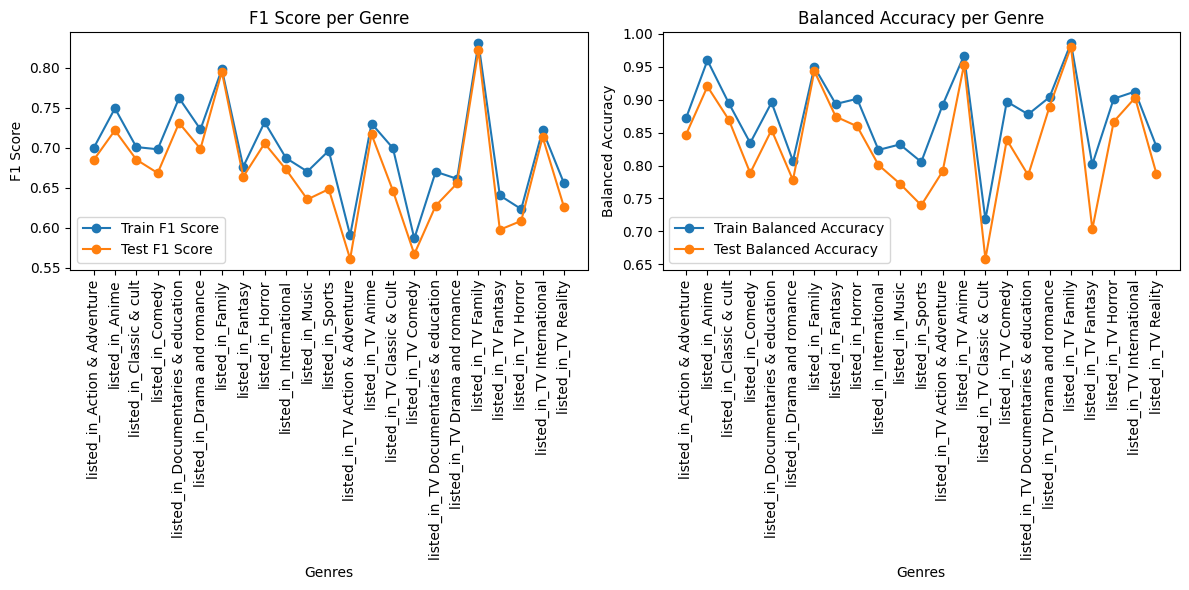

In [ ]:
from sklearn.metrics import f1_score, balanced_accuracy_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB

# Característiques (X) després d'eliminar les columnes de gènere i d'altres que no són rellevants
X = df.drop(columns=listed_ins + ['listed_in', 'rating', 'title', 'description'])

# Diccionari per emmagatzemar els resultats de classificació de cada gènere
predictions = {}

# Llistes per avaluar mètriques i detectar overfitting/underfitting
train_f1_scores = []
test_f1_scores = []
train_balanced_accuracies = []
test_balanced_accuracies = []

# Entrenament i classificació per a cada columna de gènere
for genre in listed_ins:
    y = df[genre]  # Target és la columna de gènere actual

    # Dividir el conjunt de dades en entrenament i test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # Calcular pesos per classe per balancejar les prediccions
    class_counts = y_train.value_counts()
    weights = {cls: max(class_counts) / count for cls, count in class_counts.items()}

    # Crear i entrenar el model Naive Bayes
    model = CategoricalNB()
    model.fit(X_train, y_train)

    # Predir probabilitats per a conjunt d'entrenament i test
    proba_train = model.predict_proba(X_train)
    proba_test = model.predict_proba(X_test)

    # Ajustar probabilitats amb els pesos per classe
    for cls, weight in weights.items():
        # Aquí obtenim l'índex de la classe i ajustem les probabilitats
        cls_index = list(weights.keys()).index(cls)
        proba_train[:, cls_index] *= weight
        proba_test[:, cls_index] *= weight

    # Assignar la classe amb la probabilitat ajustada més alta
    predictions_train = np.argmax(proba_train, axis=1)
    predictions_test = np.argmax(proba_test, axis=1)

    # Emmagatzemar les prediccions per al conjunt original
    predictions[genre] = np.argmax(model.predict_proba(X), axis=1)

    # Calcular mètriques per entrenament
    train_f1 = f1_score(y_train, predictions_train, average='macro')
    train_balanced_accuracy = balanced_accuracy_score(y_train, predictions_train)
    train_f1_scores.append(train_f1)
    train_balanced_accuracies.append(train_balanced_accuracy)

    # Calcular mètriques per test
    test_f1 = f1_score(y_test, predictions_test, average='macro')
    test_balanced_accuracy = balanced_accuracy_score(y_test, predictions_test)
    test_f1_scores.append(test_f1)
    test_balanced_accuracies.append(test_balanced_accuracy)

    # Mostrar resultats
    print(f"\n{genre}:")
    print(f"  F1 Score (train): {train_f1:.2f}, F1 Score (test): {test_f1:.2f}")
    print(f"  Balanced Accuracy (train): {train_balanced_accuracy:.2f}, Balanced Accuracy (test): {test_balanced_accuracy:.2f}")

    # Precision-Recall Curve per al test
    precision, recall, _ = precision_recall_curve(y_test, proba_test[:, 1], pos_label=1)
    pr_auc = auc(recall, precision)
    print(f"  Precision-Recall AUC: {pr_auc:.2f}")

# Convertir les prediccions a DataFrame
predictions_df = pd.DataFrame(predictions, index=df.index)

# Combinar els resultats en una sola columna
def combine_genres(row):
    genres = [genre.replace('listed_in_', '') for genre, value in row.items() if value == 1]
    return ', '.join(genres)

# Crear una nova columna al DataFrame original amb els gèneres classificats
df['classified_genres'] = predictions_df.apply(combine_genres, axis=1)

# Mostrar les primeres files del DataFrame amb la nova columna
print(df[['classified_genres']].head())

# Visualitzar si hi ha overfitting o underfitting
plt.figure(figsize=(12, 6))

# F1 Score
plt.subplot(1, 2, 1)
plt.plot(listed_ins, train_f1_scores, label='Train F1 Score', marker='o')
plt.plot(listed_ins, test_f1_scores, label='Test F1 Score', marker='o')
plt.title("F1 Score per Genre")
plt.xlabel("Genres")
plt.ylabel("F1 Score")
plt.legend()
plt.xticks(rotation=90)

# Balanced Accuracy
plt.subplot(1, 2, 2)
plt.plot(listed_ins, train_balanced_accuracies, label='Train Balanced Accuracy', marker='o')
plt.plot(listed_ins, test_balanced_accuracies, label='Test Balanced Accuracy', marker='o')
plt.title("Balanced Accuracy per Genre")
plt.xlabel("Genres")
plt.ylabel("Balanced Accuracy")
plt.legend()
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()



listed_in_Action & Adventure:
  F1 Score (train): 0.70, F1 Score (test): 0.68
  Balanced Accuracy (train): 0.87, Balanced Accuracy (test): 0.85
  Precision-Recall AUC: 0.39

listed_in_Anime:
  F1 Score (train): 0.75, F1 Score (test): 0.72
  Balanced Accuracy (train): 0.95, Balanced Accuracy (test): 0.92
  Precision-Recall AUC: 0.31

listed_in_Classic & cult:
  F1 Score (train): 0.70, F1 Score (test): 0.68
  Balanced Accuracy (train): 0.89, Balanced Accuracy (test): 0.87
  Precision-Recall AUC: 0.31

listed_in_Comedy:
  F1 Score (train): 0.70, F1 Score (test): 0.67
  Balanced Accuracy (train): 0.83, Balanced Accuracy (test): 0.79
  Precision-Recall AUC: 0.41

listed_in_Documentaries & education:
  F1 Score (train): 0.76, F1 Score (test): 0.73
  Balanced Accuracy (train): 0.89, Balanced Accuracy (test): 0.85
  Precision-Recall AUC: 0.41

listed_in_Drama and romance:
  F1 Score (train): 0.72, F1 Score (test): 0.70
  Balanced Accuracy (train): 0.81, Balanced Accuracy (test): 0.78
  Precis

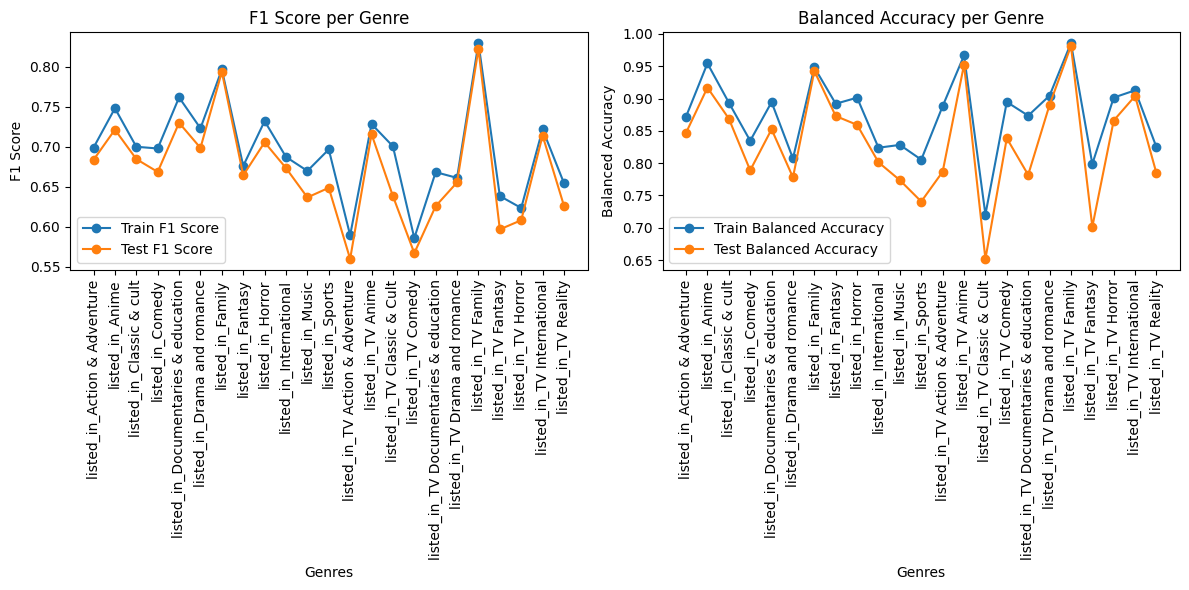

In [77]:
# Característiques (X) i etiqueta (y)
X = df.drop(columns=listed_ins + ['listed_in', 'rating', 'title', 'description'])  # Característiques

# Diccionari per emmagatzemar els resultats de classificació de cada gènere
predictions = {}

# Llistes per avaluar mètriques i detectar overfitting/underfitting
train_f1_scores = []
test_f1_scores = []
train_balanced_accuracies = []
test_balanced_accuracies = []

# Entrenament i classificació per a cada columna de gènere
for genre in listed_ins:
    y = df[genre]  # Target és la columna de gènere actual

    # Obtenir les característiques seleccionades per a aquest gènere
    selected_genre_features = list(selected_features[genre])  # Convertir el conjunt a llista
    
    # Filtrar X per utilitzar només les característiques seleccionades
    X_genre_selected = X[selected_genre_features]

    # Dividir el conjunt de dades en entrenament i test
    X_train, X_test, y_train, y_test = train_test_split(X_genre_selected, y, test_size=0.3, random_state=42, stratify=y)

    # Calcular pesos per classe per balancejar les prediccions
    class_counts = y_train.value_counts()
    weights = {cls: max(class_counts) / count for cls, count in class_counts.items()}

    # Crear i entrenar el model Naive Bayes
    model = CategoricalNB()
    model.fit(X_train, y_train)

    # Predir probabilitats per a conjunt d'entrenament i test
    proba_train = model.predict_proba(X_train)
    proba_test = model.predict_proba(X_test)

    # Ajustar probabilitats amb els pesos per classe
    for cls, weight in weights.items():
        # Aquí obtenim l'índex de la classe i ajustem les probabilitats
        cls_index = list(weights.keys()).index(cls)
        proba_train[:, cls_index] *= weight
        proba_test[:, cls_index] *= weight

    # Assignar la classe amb la probabilitat ajustada més alta
    predictions_train = np.argmax(proba_train, axis=1)
    predictions_test = np.argmax(proba_test, axis=1)

    # Emmagatzemar les prediccions per al conjunt original
    predictions[genre] = np.argmax(model.predict_proba(X_genre_selected), axis=1)

    # Calcular mètriques per entrenament
    train_f1 = f1_score(y_train, predictions_train, average='macro')
    train_balanced_accuracy = balanced_accuracy_score(y_train, predictions_train)
    train_f1_scores.append(train_f1)
    train_balanced_accuracies.append(train_balanced_accuracy)

    # Calcular mètriques per test
    test_f1 = f1_score(y_test, predictions_test, average='macro')
    test_balanced_accuracy = balanced_accuracy_score(y_test, predictions_test)
    test_f1_scores.append(test_f1)
    test_balanced_accuracies.append(test_balanced_accuracy)

    # Mostrar resultats
    print(f"\n{genre}:")
    print(f"  F1 Score (train): {train_f1:.2f}, F1 Score (test): {test_f1:.2f}")
    print(f"  Balanced Accuracy (train): {train_balanced_accuracy:.2f}, Balanced Accuracy (test): {test_balanced_accuracy:.2f}")

    # Precision-Recall Curve per al test
    precision, recall, _ = precision_recall_curve(y_test, proba_test[:, 1], pos_label=1)
    pr_auc = auc(recall, precision)
    print(f"  Precision-Recall AUC: {pr_auc:.2f}")

# Convertir les prediccions a DataFrame
predictions_df = pd.DataFrame(predictions, index=df.index)

# Combinar els resultats en una sola columna
def combine_genres(row):
    genres = [genre.replace('listed_in_', '') for genre, value in row.items() if value == 1]
    return ', '.join(genres)

# Crear una nova columna al DataFrame original amb els gèneres classificats
df['classified_genres'] = predictions_df.apply(combine_genres, axis=1)

# Mostrar les primeres files del DataFrame amb la nova columna
print(df[['classified_genres']].head())

# Visualitzar si hi ha overfitting o underfitting
plt.figure(figsize=(12, 6))

# F1 Score
plt.subplot(1, 2, 1)
plt.plot(listed_ins, train_f1_scores, label='Train F1 Score', marker='o')
plt.plot(listed_ins, test_f1_scores, label='Test F1 Score', marker='o')
plt.title("F1 Score per Genre")
plt.xlabel("Genres")
plt.ylabel("F1 Score")
plt.legend()
plt.xticks(rotation=90)

# Balanced Accuracy
plt.subplot(1, 2, 2)
plt.plot(listed_ins, train_balanced_accuracies, label='Train Balanced Accuracy', marker='o')
plt.plot(listed_ins, test_balanced_accuracies, label='Test Balanced Accuracy', marker='o')
plt.title("Balanced Accuracy per Genre")
plt.xlabel("Genres")
plt.ylabel("Balanced Accuracy")
plt.legend()
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


In [27]:

# Mostrar les primeres files del DataFrame amb la nova columna
print(df[['classified_genres']])

                                        classified_genres
0                                                  Comedy
1       TV Drama and romance, TV Horror, TV International
2       TV Drama and romance, TV Horror, TV International
3       TV Drama and romance, TV Horror, TV International
4                  TV Drama and romance, TV International
...                                                   ...
201954                                      International
201955                                      International
201956                   Drama and romance, International
201957                   Drama and romance, International
201958                   Drama and romance, International

[201959 rows x 1 columns]


### **4.1 AVALUACIÓ I SEL·LECCIÓ DE LES MÈTRIQUES**

### **4.2 REPRESENTACIÓ GRÀFICA**

# **5. HYPERPARAMETER SELECTION**

# **6. DATA TRAINNING**

# **7. RECCOMENDATION**

Historial de visualització: Netflix analitza quins títols has vist (pel·lícules, sèries, documentals), el temps que hi has dedicat i si els has acabat o no. Si acabes una sèrie, es considera que t’ha agradat més que si només en veus un episodi o l'abandones a mitges.

Categories de gènere i temàtica: Cada títol a Netflix està etiquetat amb múltiples categories (per exemple, "comèdia romàntica", "drama policíac", "ciència ficció"). El sistema detecta els gèneres i subgèneres que més consumeixes per recomanar-te contingut similar.

Valoracions i reaccions dels usuaris: Netflix també considera si fas clic a “M'agrada” o “No m'agrada” en certs títols. Aquestes interaccions ajuden a perfilar millor el teu gust.

Moment i context de visualització: L'algoritme pot captar patrons en els moments en què consumes determinats tipus de contingut. Per exemple, potser prefereixes veure sèries llargues durant el cap de setmana i pel·lícules d'acció a la nit.

Popularitat a la teva regió: Netflix té en compte les tendències locals. Si hi ha títols que estan de moda en el teu país o regió, tenen més probabilitat d'aparèixer en les recomanacions, fins i tot si no segueixen les teves preferències històriques.

Anàlisi de similitud d'usuaris (collaborative filtering): Mitjançant tècniques de “filtratge col·laboratiu”, Netflix compara el teu perfil amb altres usuaris amb gustos similars i recomana contingut que altres usuaris amb preferències semblants han vist i valorat positivament.

Contingut similar: Netflix també pot fer servir un model de "content-based filtering", que recomana continguts similars als que ja has vist. Això es basa en característiques de les pel·lícules i sèries, com actors, directors o gèneres comuns.

type: Aquest atribut especifica si el contingut és una pel·lícula o una sèrie. Pot ajudar a filtrar recomanacions segons el tipus que l'usuari prefereixi, ja que algunes persones poden tenir una preferència clara per un tipus de format sobre l'altre.

listed_in: Aquest atribut representa els gèneres o categories (com comèdia, drama, acció, documentals, etc.) en què s’emmarca el contingut. És probablement dels més importants, ja que els usuaris tenen tendència a preferir certs gèneres i subgèneres.

cast i director: Aquests atributs són útils perquè moltes persones tenen preferències per certs actors o directors. Si l'usuari ha vist diversos continguts amb el mateix actor o director, es pot deduir que és una característica atractiva per a ell.

country: El país de producció pot influir en les preferències, ja que pot indicar una preferència per continguts d'una cultura o regió específica. Això és especialment rellevant en les plataformes globals com Netflix, que ofereixen continguts d'arreu del món.

release_year: L'any d'estrena pot ajudar a recomanar contingut segons preferències de dècades o períodes concrets. Si algú prefereix contingut modern o, per contra, pel·lícules i sèries clàssiques, aquest atribut és rellevant.

duration: Tot i que no sempre és clau, la durada pot ser útil per ajustar les recomanacions en funció de l'estil de visualització de l'usuari. Per exemple, si algú sol veure continguts més curts, es poden prioritzar les pel·lícules o sèries amb episodis més breus.

rating: La classificació per edat pot ser útil si l'algoritme detecta preferències per certs nivells de maduresa del contingut (com "PG-13", "R", etc.). També pot ser útil si es volen fer recomanacions adequades per a una audiència de certa edat.

description: Tot i que no és un atribut directe per a les recomanacions, es podria analitzar amb processament de llenguatge natural per extreure paraules clau que permetin recomanar contingut amb temàtiques similars.

Atributs menys rellevants:
show_id: És només un identificador únic per a cada registre i no aporta informació sobre les preferències de l'usuari.
title: En general, el títol per si sol no aporta informació rellevant per a la recomanació, tot i que podria utilitzar-se com a punt de partida per buscar patrons en sèries o franquícies similars.
En conjunt, podries crear un sistema de recomanació combinant factors com els gèneres (listed_in), el tipus de contingut (type), els actors i directors (cast, director), el país de producció (country), i l'any d'estrena (release_year) per fer una proposta ajustada als interessos de l'usuari.

Un cop classificat l'atribut *listed_in*, plantegem els possibles recomanadors que podem implementar: 
* **Content-Based Filtering**: Recomana pel·lícules similars a les que l'usuari ja ha vist basant-se en atributs (gèneres, actors, director, descripció...).
* **Collaborative Filtering**: Recomana pel·lícules basant-se en preferències similars d'altres usuaris que han vist pel·lícules semblants.

Basant-nos en el nostre dataset considerem adient la primera opció. 

Filtratge inicial:
Si coneixes el gènere preferit de l’usuari, el classificador pot ajudar a filtrar pel·lícules del dataset que s'ajustin a aquest gènere abans de calcular les similituds.
Millora del rendiment:
Redueix la cerca a un subconjunt més petit de pel·lícules, la qual cosa pot millorar l'eficiència del recomanador en datasets grans.


In [ ]:

X = df.drop('title', 'description', 'listed_in', 'rating')
y = df['title']

print(X.columns)

Index(['type', 'director', 'cast', 'country', 'release_year', 'rating',
       'duration', 'listed_in', 'description', 'rating_G', 'rating_NC-17',
       'rating_NR', 'rating_PG', 'rating_PG-13', 'rating_R', 'rating_TV-14',
       'rating_TV-G', 'rating_TV-MA', 'rating_TV-PG', 'rating_TV-Y',
       'rating_TV-Y7', 'rating_TV-Y7-FV', 'rating_UR',
       'listed_in_Action & Adventure', 'listed_in_Anime',
       'listed_in_Classic & cult', 'listed_in_Comedy',
       'listed_in_Documentaries & education', 'listed_in_Drama and romance',
       'listed_in_Family', 'listed_in_Fantasy', 'listed_in_Horror',
       'listed_in_International', 'listed_in_Music', 'listed_in_Sports',
       'listed_in_TV Action & Adventure', 'listed_in_TV Anime',
       'listed_in_TV Classic & Cult', 'listed_in_TV Comedy',
       'listed_in_TV Documentaries & education',
       'listed_in_TV Drama and romance', 'listed_in_TV Family',
       'listed_in_TV Fantasy', 'listed_in_TV Horror',
       'listed_in_TV Internat

In [98]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

X = df.drop(columns=['title', 'description', 'listed_in', 'rating'])
y = df['title']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 45, stratify= y)

#train = pd.concat([y_train, X_train], axis=1)

# Converteix la columna de "features" en un array NumPy per calcular similituds
# Creem la matriu de característiques a partir de les columnes de X
feature_matrix = np.array(X.values.tolist())


# Pas 1: Funció per calcular recomanacions
def get_recommendations(title, feature_matrix, df):
    # Troba l'índex de la pel·lícula basada en el títol
    idx = df[df['title'] == title].index[0]
    
    # Calcula la similitud cosinus entre aquesta pel·lícula i totes les altres
    cosine_sim = cosine_similarity([feature_matrix[idx]], feature_matrix).flatten()
    
    # Ordena per similitud i obté els índexs de les pel·lícules més similars
    similar_indices = cosine_sim.argsort()[-6:][::-1]  # Agafa les 5 millors similituds (excloent la pròpia pel·lícula)
    
    # Retorna les pel·lícules similars (excloent la mateixa)
    similar_movies = df.iloc[similar_indices[1:]]  # Exclou el primer, que és la pel·lícula en si
    return similar_movies[['title']]

# Prova amb una pel·lícula
movie_title = "Inception"
recommendations = get_recommendations(movie_title, feature_matrix, df)

# Mostra les recomanacions
print(f"Recomanacions per a la pel·lícula '{movie_title}':")
print(recommendations)


Recomanacions per a la pel·lícula 'Inception':
                  title
8267          Inception
8266          Inception
194219  The Prince & Me
194218  The Prince & Me
98412        All of You
